In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import japanize_matplotlib
from IPython.display import display

# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

### GPUチェック

In [3]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## データの読み込み

In [4]:
df = pd.read_csv('n1c1o.csv')
df2 = pd.read_csv('n1c1p.csv')
df3 = pd.read_csv('n1c3o.csv')
df4 = pd.read_csv('n3c1o.csv')

In [ ]:
phi = np.array( df.columns).astype(float)
phi2 = np.array( df2.columns).astype(float)
phi3 = np.array( df3.columns).astype(float)
phi4 = np.array( df4.columns).astype(float)

In [89]:
x = np.array(df).astype(complex)
x2 = np.array(df2).astype(complex)
x3 = np.array(df3).astype(complex)
x4 = np.array(df4).astype(complex)

#absでいい？absにしなくてもerrorはでないと思う　実部と虚部にわかる
x = np.abs( x )
x2 = np.abs(x2)
x3 = np.abs(x3)
x4 = np.abs(x4)

In [91]:
#ひとつにまとめる
x_data = np.vstack([x, x2, x3, x4])
y_data = np.hstack([np.array( [0]* 800 ),
                    np.array( [1]* 800 ),
                    np.array( [2]* 800 ),
                    np.array( [3]* 800 )
                   ])
# train setと検証 set に分割
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2400, 20000) (800, 20000) (2400,) (800,)


## 9.4 PyTorchでのCNN実装

### nn.Conv1d とnn.MaxPool1d

In [92]:
# CNN前半部分 レイヤー関数の定義
conv1 = nn.Conv1d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv1d(32, 32, 3)
maxpool = nn.MaxPool1d(kernel_size=5)

### nn.Sequential

In [93]:
# 関数定義
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

### nn.Flatten

In [94]:
# 関数定義
flatten = nn.Flatten()

## 9.4 共通関数の定義

### eval_loss 損失計算用

In [95]:
# モデルの引数と入力が同じ型でないとエラーが出るためいたるところにfloat()とlong()があるがこんなになくてもいい
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device).float()
    labels = labels.to(device).long()

    # 予測計算
    outputs = net(inputs.float())

    #  損失計算
    loss = criterion(outputs.float(), labels.long())

    return loss

### fit 学習用

In [98]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            net = net.float()
            outputs = net(inputs.float()).float()
            
            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### eval_history 学習ログ解析用

In [99]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure()
    plt.plot(history[:,0], history[:,1], c = 'r', label='train')
    plt.plot(history[:,0], history[:,3],  c = 'c', label='validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('number epoch')
    plt.ylabel('loss')
    plt.title('Learning Curve(loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure()
    plt.plot(history[:,0], history[:,2], 'r', label='train')
    plt.plot(history[:,0], history[:,4], c = 'c', label='validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('number epoch')
    plt.ylabel('accuracy')
    plt.title('Learning Curve(accuracy)')
    plt.legend()
    plt.show()

### torch_seed 乱数固定用

In [100]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

## データ準備

### データセットの確認

In [101]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

In [102]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)

torch.Size([100, 20000])


## モデル定義(全結合版)

### 学習用パラメータ設定

In [103]:
#n_input = image1.view(-1).shape[0]
n_input = images1[0].shape
# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels1.data.numpy())))

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: torch.Size([20000])  n_hidden: 128 n_output: 4


In [104]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv1d(100, 50, 5)
    self.conv2 = nn.Conv1d(50, 100, 5)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool1d(5)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(3998, 1024)
    self.l2 = nn.Linear(1024, 256)
    self.l3 = nn.Linear(256, 32)
    self.l4 = nn.Linear(32, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
        self.relu,
        self.l3,
        self.relu,
        self.l4
    )

  def forward(self, x):
    x1 = ( self.features(x.float()) ).float()
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

### モデルインスタンス生成とGPUの割り当て

In [105]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [106]:
# モデルの概要表示
print(net)

CNN(
  (conv1): Conv1d(100, 50, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(50, 100, kernel_size=(5,), stride=(1,))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=3998, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=32, bias=True)
  (l4): Linear(in_features=32, out_features=4, bias=True)
  (features): Sequential(
    (0): Conv1d(100, 50, kernel_size=(5,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(50, 100, kernel_size=(5,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3998, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3):

In [107]:
# モデルのサマリー表示
#google colab ならエラーは出ない。pathを通せばエラーなくいける
#summary(net, (100,3072),depth=1)

In [108]:
conv1 = nn.Conv1d(100, 50, 5)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv1d(50, 100, 5)
maxpool = nn.MaxPool1d(5)
l1 = nn.Linear(3998, 128)
l2 = nn.Linear(128, n_output)

inputs = images1.to(device)
print(inputs.shape)
x = conv1(inputs)
print(x.shape)
x = relu(x)
print(x.shape)
x = conv2(x)
print(x3.shape)
x = relu(x)
print(x.shape)
x = maxpool(x)
print(x.shape)
x = flatten(x)
print(x.shape)
x = l1(x)
print(x.shape)
x = relu(x)
print(x.shape)
x = l2(x)
print(x.shape)

torch.Size([100, 20000])
torch.Size([50, 19996])
torch.Size([50, 19996])
(800, 20000)
torch.Size([100, 19992])
torch.Size([100, 3998])
torch.Size([100, 3998])
torch.Size([100, 128])
torch.Size([100, 128])
torch.Size([100, 4])


In [110]:
# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

# 損失の計算グラフ可視化
#google colab ならエラーは出ない。pathを通せばエラーなくいける
#g = make_dot(loss, params=dict(net.named_parameters()))
#display(g)

## 結果(CNN版)

### 学習

In [111]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history2)

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [1/250], loss: 0.01390 acc: 0.24458 val_loss: 0.01390, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [2/250], loss: 0.01390 acc: 0.24458 val_loss: 0.01389, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [3/250], loss: 0.01389 acc: 0.24458 val_loss: 0.01389, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [4/250], loss: 0.01389 acc: 0.24458 val_loss: 0.01389, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [5/250], loss: 0.01389 acc: 0.24458 val_loss: 0.01388, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [6/250], loss: 0.01388 acc: 0.24458 val_loss: 0.01388, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [7/250], loss: 0.01388 acc: 0.24458 val_loss: 0.01388, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [8/250], loss: 0.01388 acc: 0.24458 val_loss: 0.01388, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [9/250], loss: 0.01388 acc: 0.24458 val_loss: 0.01387, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [10/250], loss: 0.01387 acc: 0.24458 val_loss: 0.01387, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [11/250], loss: 0.01387 acc: 0.24458 val_loss: 0.01387, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [12/250], loss: 0.01387 acc: 0.24458 val_loss: 0.01387, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [13/250], loss: 0.01387 acc: 0.24458 val_loss: 0.01387, val_acc: 0.24458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [14/250], loss: 0.01387 acc: 0.24417 val_loss: 0.01387, val_acc: 0.24667


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [15/250], loss: 0.01387 acc: 0.24958 val_loss: 0.01387, val_acc: 0.23917


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [16/250], loss: 0.01387 acc: 0.25458 val_loss: 0.01387, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [17/250], loss: 0.01387 acc: 0.25250 val_loss: 0.01387, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [18/250], loss: 0.01387 acc: 0.25333 val_loss: 0.01387, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [19/250], loss: 0.01387 acc: 0.25333 val_loss: 0.01387, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [20/250], loss: 0.01387 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [21/250], loss: 0.01387 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [22/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [23/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [24/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [25/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [26/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [27/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [28/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [29/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [30/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [31/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [32/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [33/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [34/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [35/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [36/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [37/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [38/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [39/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [40/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [41/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [42/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [43/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [44/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [45/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [46/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [47/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [48/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [49/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [50/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [51/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [52/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [53/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [54/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [55/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [56/250], loss: 0.01386 acc: 0.24292 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [57/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [58/250], loss: 0.01386 acc: 0.24042 val_loss: 0.01386, val_acc: 0.24125


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [59/250], loss: 0.01386 acc: 0.23917 val_loss: 0.01386, val_acc: 0.24750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [60/250], loss: 0.01386 acc: 0.24458 val_loss: 0.01386, val_acc: 0.26208


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [61/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.24583


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [62/250], loss: 0.01386 acc: 0.24458 val_loss: 0.01386, val_acc: 0.26667


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [63/250], loss: 0.01386 acc: 0.25167 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [64/250], loss: 0.01386 acc: 0.23167 val_loss: 0.01386, val_acc: 0.25167


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [65/250], loss: 0.01386 acc: 0.24167 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [66/250], loss: 0.01386 acc: 0.24500 val_loss: 0.01386, val_acc: 0.26250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [67/250], loss: 0.01386 acc: 0.24583 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [68/250], loss: 0.01386 acc: 0.24875 val_loss: 0.01386, val_acc: 0.24667


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [69/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.26542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [70/250], loss: 0.01386 acc: 0.24208 val_loss: 0.01386, val_acc: 0.25875


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [71/250], loss: 0.01386 acc: 0.23750 val_loss: 0.01386, val_acc: 0.25917


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [72/250], loss: 0.01386 acc: 0.23917 val_loss: 0.01386, val_acc: 0.26250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [73/250], loss: 0.01386 acc: 0.24417 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [74/250], loss: 0.01386 acc: 0.23542 val_loss: 0.01386, val_acc: 0.24792


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [75/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.26000


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [76/250], loss: 0.01386 acc: 0.24417 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [77/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.24583


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [78/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.25625


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [79/250], loss: 0.01386 acc: 0.25042 val_loss: 0.01386, val_acc: 0.25667


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [80/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.24625


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [81/250], loss: 0.01386 acc: 0.24500 val_loss: 0.01386, val_acc: 0.24875


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [82/250], loss: 0.01386 acc: 0.25167 val_loss: 0.01386, val_acc: 0.25750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [83/250], loss: 0.01386 acc: 0.24458 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [84/250], loss: 0.01386 acc: 0.24500 val_loss: 0.01386, val_acc: 0.25583


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [85/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25208


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [86/250], loss: 0.01386 acc: 0.25125 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [87/250], loss: 0.01386 acc: 0.24917 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [88/250], loss: 0.01386 acc: 0.24083 val_loss: 0.01386, val_acc: 0.25208


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [89/250], loss: 0.01386 acc: 0.24208 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [90/250], loss: 0.01386 acc: 0.24042 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [91/250], loss: 0.01386 acc: 0.25500 val_loss: 0.01386, val_acc: 0.25083


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [92/250], loss: 0.01386 acc: 0.24625 val_loss: 0.01386, val_acc: 0.25667


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [93/250], loss: 0.01386 acc: 0.24583 val_loss: 0.01386, val_acc: 0.25750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [94/250], loss: 0.01386 acc: 0.24625 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [95/250], loss: 0.01386 acc: 0.24625 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [96/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.25750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [97/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.25625


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [98/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [99/250], loss: 0.01386 acc: 0.24917 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [100/250], loss: 0.01386 acc: 0.24125 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [101/250], loss: 0.01386 acc: 0.25458 val_loss: 0.01386, val_acc: 0.25583


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [102/250], loss: 0.01386 acc: 0.25625 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [103/250], loss: 0.01386 acc: 0.24667 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [104/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [105/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [106/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [107/250], loss: 0.01386 acc: 0.25583 val_loss: 0.01386, val_acc: 0.25167


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [108/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.25042


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [109/250], loss: 0.01386 acc: 0.24542 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [110/250], loss: 0.01386 acc: 0.24792 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [111/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [112/250], loss: 0.01386 acc: 0.24583 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [113/250], loss: 0.01386 acc: 0.25417 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [114/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [115/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.25167


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [116/250], loss: 0.01386 acc: 0.25208 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [117/250], loss: 0.01386 acc: 0.24875 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [118/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [119/250], loss: 0.01386 acc: 0.24667 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [120/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [121/250], loss: 0.01386 acc: 0.26458 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [122/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [123/250], loss: 0.01386 acc: 0.24292 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [124/250], loss: 0.01386 acc: 0.24250 val_loss: 0.01386, val_acc: 0.25125


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [125/250], loss: 0.01386 acc: 0.24250 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [126/250], loss: 0.01386 acc: 0.25500 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [127/250], loss: 0.01386 acc: 0.26083 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [128/250], loss: 0.01386 acc: 0.25458 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [129/250], loss: 0.01386 acc: 0.25208 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [130/250], loss: 0.01386 acc: 0.25625 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [131/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25125


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [132/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [133/250], loss: 0.01386 acc: 0.25125 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [134/250], loss: 0.01386 acc: 0.24875 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [135/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [136/250], loss: 0.01386 acc: 0.23833 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [137/250], loss: 0.01386 acc: 0.24375 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [138/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.24958


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [139/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [140/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [141/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [142/250], loss: 0.01386 acc: 0.25167 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [143/250], loss: 0.01386 acc: 0.24792 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [144/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [145/250], loss: 0.01386 acc: 0.25458 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [146/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [147/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [148/250], loss: 0.01386 acc: 0.25167 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [149/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [150/250], loss: 0.01386 acc: 0.24125 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [151/250], loss: 0.01386 acc: 0.24625 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [152/250], loss: 0.01386 acc: 0.25417 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [153/250], loss: 0.01386 acc: 0.24083 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [154/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [155/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [156/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [157/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [158/250], loss: 0.01386 acc: 0.24000 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [159/250], loss: 0.01386 acc: 0.24750 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [160/250], loss: 0.01386 acc: 0.25208 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [161/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [162/250], loss: 0.01386 acc: 0.25667 val_loss: 0.01386, val_acc: 0.25167


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [163/250], loss: 0.01386 acc: 0.24458 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [164/250], loss: 0.01386 acc: 0.25458 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [165/250], loss: 0.01386 acc: 0.26500 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [166/250], loss: 0.01386 acc: 0.25417 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [167/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [168/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [169/250], loss: 0.01386 acc: 0.24500 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [170/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [171/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [172/250], loss: 0.01386 acc: 0.24250 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [173/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [174/250], loss: 0.01386 acc: 0.24000 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [175/250], loss: 0.01386 acc: 0.24375 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [176/250], loss: 0.01386 acc: 0.25417 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [177/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [178/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [179/250], loss: 0.01386 acc: 0.24125 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [180/250], loss: 0.01386 acc: 0.24583 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [181/250], loss: 0.01386 acc: 0.24750 val_loss: 0.01386, val_acc: 0.25500


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [182/250], loss: 0.01386 acc: 0.24667 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [183/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [184/250], loss: 0.01386 acc: 0.25458 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [185/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [186/250], loss: 0.01386 acc: 0.25500 val_loss: 0.01386, val_acc: 0.25042


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [187/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [188/250], loss: 0.01386 acc: 0.25000 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [189/250], loss: 0.01386 acc: 0.24542 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [190/250], loss: 0.01386 acc: 0.24750 val_loss: 0.01386, val_acc: 0.25875


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [191/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.26083


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [192/250], loss: 0.01386 acc: 0.24125 val_loss: 0.01386, val_acc: 0.25208


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [193/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.24708


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [194/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.25250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [195/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25917


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [196/250], loss: 0.01386 acc: 0.25458 val_loss: 0.01386, val_acc: 0.25958


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [197/250], loss: 0.01386 acc: 0.25167 val_loss: 0.01386, val_acc: 0.25167


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [198/250], loss: 0.01386 acc: 0.24958 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [199/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.24708


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [200/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.24958


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [201/250], loss: 0.01386 acc: 0.24167 val_loss: 0.01386, val_acc: 0.25417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [202/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [203/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25667


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [204/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.26250


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [205/250], loss: 0.01386 acc: 0.25542 val_loss: 0.01386, val_acc: 0.25375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [206/250], loss: 0.01386 acc: 0.24667 val_loss: 0.01386, val_acc: 0.25083


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [207/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25042


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [208/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.24750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [209/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25667


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [210/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.25625


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [211/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.25833


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [212/250], loss: 0.01386 acc: 0.24917 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [213/250], loss: 0.01386 acc: 0.25417 val_loss: 0.01386, val_acc: 0.25042


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [214/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [215/250], loss: 0.01386 acc: 0.24875 val_loss: 0.01386, val_acc: 0.25292


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [216/250], loss: 0.01386 acc: 0.24292 val_loss: 0.01386, val_acc: 0.25708


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [217/250], loss: 0.01386 acc: 0.24542 val_loss: 0.01386, val_acc: 0.25125


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [218/250], loss: 0.01386 acc: 0.25250 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [219/250], loss: 0.01386 acc: 0.24917 val_loss: 0.01386, val_acc: 0.25958


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [220/250], loss: 0.01386 acc: 0.24458 val_loss: 0.01386, val_acc: 0.24875


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [221/250], loss: 0.01386 acc: 0.25042 val_loss: 0.01386, val_acc: 0.25792


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [222/250], loss: 0.01386 acc: 0.24542 val_loss: 0.01386, val_acc: 0.25167


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [223/250], loss: 0.01386 acc: 0.24167 val_loss: 0.01386, val_acc: 0.26125


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [224/250], loss: 0.01386 acc: 0.24333 val_loss: 0.01386, val_acc: 0.26417


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [225/250], loss: 0.01386 acc: 0.24625 val_loss: 0.01386, val_acc: 0.24792


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [226/250], loss: 0.01386 acc: 0.24875 val_loss: 0.01386, val_acc: 0.24750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [227/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.24750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [228/250], loss: 0.01386 acc: 0.24750 val_loss: 0.01386, val_acc: 0.24625


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [229/250], loss: 0.01386 acc: 0.24917 val_loss: 0.01386, val_acc: 0.25542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [230/250], loss: 0.01386 acc: 0.24042 val_loss: 0.01386, val_acc: 0.25833


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [231/250], loss: 0.01386 acc: 0.25625 val_loss: 0.01386, val_acc: 0.25333


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [232/250], loss: 0.01386 acc: 0.24667 val_loss: 0.01386, val_acc: 0.25083


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [233/250], loss: 0.01386 acc: 0.24833 val_loss: 0.01386, val_acc: 0.26042


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [234/250], loss: 0.01386 acc: 0.26083 val_loss: 0.01386, val_acc: 0.24375


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [235/250], loss: 0.01386 acc: 0.24292 val_loss: 0.01386, val_acc: 0.24583


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [236/250], loss: 0.01386 acc: 0.24667 val_loss: 0.01386, val_acc: 0.25458


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [237/250], loss: 0.01386 acc: 0.25375 val_loss: 0.01386, val_acc: 0.23875


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [238/250], loss: 0.01386 acc: 0.24875 val_loss: 0.01386, val_acc: 0.25708


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [239/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.24833


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [240/250], loss: 0.01386 acc: 0.25625 val_loss: 0.01386, val_acc: 0.24875


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [241/250], loss: 0.01386 acc: 0.25083 val_loss: 0.01386, val_acc: 0.25083


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [242/250], loss: 0.01386 acc: 0.25542 val_loss: 0.01386, val_acc: 0.24833


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [243/250], loss: 0.01386 acc: 0.25292 val_loss: 0.01386, val_acc: 0.26125


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [244/250], loss: 0.01386 acc: 0.25167 val_loss: 0.01386, val_acc: 0.24583


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [245/250], loss: 0.01386 acc: 0.24208 val_loss: 0.01386, val_acc: 0.24750


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [246/250], loss: 0.01386 acc: 0.23625 val_loss: 0.01386, val_acc: 0.26542


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [247/250], loss: 0.01386 acc: 0.25500 val_loss: 0.01386, val_acc: 0.25208


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [248/250], loss: 0.01386 acc: 0.25042 val_loss: 0.01386, val_acc: 0.25708


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [249/250], loss: 0.01386 acc: 0.24792 val_loss: 0.01386, val_acc: 0.25167


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [250/250], loss: 0.01386 acc: 0.25333 val_loss: 0.01386, val_acc: 0.25583


### 評価

初期状態: 損失: 0.01390 精度: 0.24458
最終状態: 損失: 0.01386 精度: 0.25583


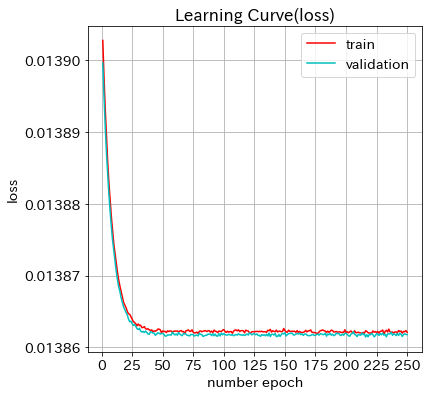

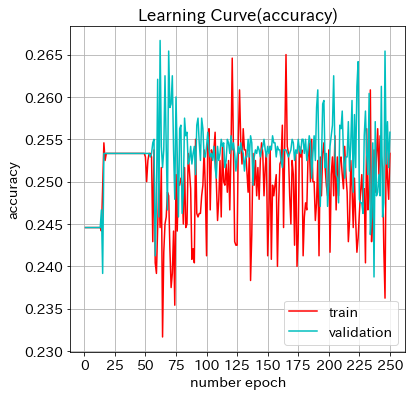

In [112]:
# 評価
evaluate_history(history2)

# いろいろCNNをいじってみる

batch_size, 層の変更、学習率、dropoutの追加などなど

ミニバッチのサイズの変更100→５０
層の変更

In [113]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 25

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv1d(batch_size, 10, 5)
    self.conv2 = nn.Conv1d(10, batch_size, 5)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool1d(5)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(3998, 512)
    self.l2 = nn.Linear(512, n_output)
    
    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x1 = ( self.features(x.float()) ).float()
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# モデルの概要表示
print(net)

# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 250

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history2)

# 評価
evaluate_history(history2)

torch.Size([25, 20000])
CNN(
  (conv1): Conv1d(25, 10, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(10, 25, kernel_size=(5,), stride=(1,))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=3998, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=4, bias=True)
  (features): Sequential(
    (0): Conv1d(25, 10, kernel_size=(5,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(10, 25, kernel_size=(5,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3998, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [1/250], loss: 0.05547 acc: 0.25292 val_loss: 0.05547, val_acc: 0.25583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [2/250], loss: 0.05546 acc: 0.25792 val_loss: 0.05544, val_acc: 0.26000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [3/250], loss: 0.05547 acc: 0.24583 val_loss: 0.05544, val_acc: 0.25375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [4/250], loss: 0.05546 acc: 0.25583 val_loss: 0.05543, val_acc: 0.25208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [5/250], loss: 0.05545 acc: 0.25708 val_loss: 0.05546, val_acc: 0.26458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [6/250], loss: 0.05546 acc: 0.26000 val_loss: 0.05544, val_acc: 0.25625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [7/250], loss: 0.05545 acc: 0.24625 val_loss: 0.05543, val_acc: 0.25958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [8/250], loss: 0.05544 acc: 0.26292 val_loss: 0.05542, val_acc: 0.26750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [9/250], loss: 0.05542 acc: 0.26125 val_loss: 0.05541, val_acc: 0.27042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [10/250], loss: 0.05541 acc: 0.26417 val_loss: 0.05537, val_acc: 0.27917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [11/250], loss: 0.05544 acc: 0.25708 val_loss: 0.05541, val_acc: 0.27750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [12/250], loss: 0.05539 acc: 0.27667 val_loss: 0.05539, val_acc: 0.27167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [13/250], loss: 0.05534 acc: 0.28792 val_loss: 0.05540, val_acc: 0.25792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [14/250], loss: 0.05544 acc: 0.26583 val_loss: 0.05540, val_acc: 0.26667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [15/250], loss: 0.05541 acc: 0.27833 val_loss: 0.05541, val_acc: 0.25792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [16/250], loss: 0.05538 acc: 0.25625 val_loss: 0.05532, val_acc: 0.28292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [17/250], loss: 0.05539 acc: 0.26583 val_loss: 0.05534, val_acc: 0.26958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [18/250], loss: 0.05535 acc: 0.26750 val_loss: 0.05532, val_acc: 0.28333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [19/250], loss: 0.05533 acc: 0.28458 val_loss: 0.05535, val_acc: 0.27125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [20/250], loss: 0.05528 acc: 0.29500 val_loss: 0.05528, val_acc: 0.27500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [21/250], loss: 0.05525 acc: 0.27792 val_loss: 0.05521, val_acc: 0.28208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [22/250], loss: 0.05528 acc: 0.27667 val_loss: 0.05519, val_acc: 0.28083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [23/250], loss: 0.05524 acc: 0.28333 val_loss: 0.05511, val_acc: 0.28333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [24/250], loss: 0.05514 acc: 0.29167 val_loss: 0.05511, val_acc: 0.27333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [25/250], loss: 0.05495 acc: 0.29958 val_loss: 0.05509, val_acc: 0.28500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [26/250], loss: 0.05493 acc: 0.26917 val_loss: 0.05481, val_acc: 0.29667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [27/250], loss: 0.05497 acc: 0.29583 val_loss: 0.05497, val_acc: 0.27542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [28/250], loss: 0.05492 acc: 0.28750 val_loss: 0.05491, val_acc: 0.28542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [29/250], loss: 0.05471 acc: 0.30625 val_loss: 0.05481, val_acc: 0.28917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [30/250], loss: 0.05466 acc: 0.29000 val_loss: 0.05447, val_acc: 0.29000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [31/250], loss: 0.05429 acc: 0.30000 val_loss: 0.05440, val_acc: 0.30958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [32/250], loss: 0.05406 acc: 0.32375 val_loss: 0.05432, val_acc: 0.29333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [33/250], loss: 0.05387 acc: 0.32167 val_loss: 0.05368, val_acc: 0.32417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [34/250], loss: 0.05352 acc: 0.32042 val_loss: 0.05335, val_acc: 0.33625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [35/250], loss: 0.05283 acc: 0.35167 val_loss: 0.05274, val_acc: 0.33375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [36/250], loss: 0.05292 acc: 0.34792 val_loss: 0.05277, val_acc: 0.34958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [37/250], loss: 0.05210 acc: 0.36292 val_loss: 0.05224, val_acc: 0.34167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [38/250], loss: 0.05147 acc: 0.36625 val_loss: 0.05139, val_acc: 0.37000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [39/250], loss: 0.05116 acc: 0.37708 val_loss: 0.05067, val_acc: 0.39417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [40/250], loss: 0.05046 acc: 0.38625 val_loss: 0.04993, val_acc: 0.39875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [41/250], loss: 0.04999 acc: 0.39583 val_loss: 0.04928, val_acc: 0.40875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [42/250], loss: 0.04812 acc: 0.41667 val_loss: 0.04863, val_acc: 0.41458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [43/250], loss: 0.04809 acc: 0.40458 val_loss: 0.04779, val_acc: 0.40333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [44/250], loss: 0.04687 acc: 0.42750 val_loss: 0.04681, val_acc: 0.42417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [45/250], loss: 0.04723 acc: 0.42250 val_loss: 0.04584, val_acc: 0.45542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [46/250], loss: 0.04622 acc: 0.42792 val_loss: 0.04633, val_acc: 0.42750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [47/250], loss: 0.04508 acc: 0.43292 val_loss: 0.04568, val_acc: 0.43500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [48/250], loss: 0.04539 acc: 0.43917 val_loss: 0.04449, val_acc: 0.45417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [49/250], loss: 0.04396 acc: 0.46333 val_loss: 0.04372, val_acc: 0.47250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [50/250], loss: 0.04393 acc: 0.44083 val_loss: 0.04421, val_acc: 0.45667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [51/250], loss: 0.04397 acc: 0.45250 val_loss: 0.04331, val_acc: 0.48875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [52/250], loss: 0.04346 acc: 0.46750 val_loss: 0.04263, val_acc: 0.46625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [53/250], loss: 0.04340 acc: 0.45542 val_loss: 0.04259, val_acc: 0.47125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [54/250], loss: 0.04213 acc: 0.46958 val_loss: 0.04163, val_acc: 0.48208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [55/250], loss: 0.04183 acc: 0.49208 val_loss: 0.04196, val_acc: 0.48042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [56/250], loss: 0.04209 acc: 0.48958 val_loss: 0.04119, val_acc: 0.47917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [57/250], loss: 0.04108 acc: 0.50667 val_loss: 0.04172, val_acc: 0.47000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [58/250], loss: 0.04111 acc: 0.49250 val_loss: 0.04087, val_acc: 0.52083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [59/250], loss: 0.04068 acc: 0.49167 val_loss: 0.04058, val_acc: 0.52792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [60/250], loss: 0.03968 acc: 0.50833 val_loss: 0.04003, val_acc: 0.50583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [61/250], loss: 0.03948 acc: 0.49500 val_loss: 0.03947, val_acc: 0.48333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [62/250], loss: 0.03922 acc: 0.50750 val_loss: 0.03881, val_acc: 0.50583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [63/250], loss: 0.03900 acc: 0.51250 val_loss: 0.03930, val_acc: 0.51625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [64/250], loss: 0.03908 acc: 0.52375 val_loss: 0.03824, val_acc: 0.53208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [65/250], loss: 0.03916 acc: 0.51792 val_loss: 0.03826, val_acc: 0.55250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [66/250], loss: 0.03851 acc: 0.52875 val_loss: 0.03801, val_acc: 0.54208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [67/250], loss: 0.03775 acc: 0.55417 val_loss: 0.03773, val_acc: 0.51333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [68/250], loss: 0.03807 acc: 0.53083 val_loss: 0.03773, val_acc: 0.54917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [69/250], loss: 0.03753 acc: 0.54667 val_loss: 0.03763, val_acc: 0.54208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [70/250], loss: 0.03730 acc: 0.53792 val_loss: 0.03672, val_acc: 0.55833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [71/250], loss: 0.03683 acc: 0.55542 val_loss: 0.03563, val_acc: 0.56667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [72/250], loss: 0.03667 acc: 0.55083 val_loss: 0.03629, val_acc: 0.55958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [73/250], loss: 0.03635 acc: 0.54667 val_loss: 0.03687, val_acc: 0.54708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [74/250], loss: 0.03604 acc: 0.55875 val_loss: 0.03600, val_acc: 0.55208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [75/250], loss: 0.03538 acc: 0.56208 val_loss: 0.03660, val_acc: 0.51625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [76/250], loss: 0.03600 acc: 0.54250 val_loss: 0.03514, val_acc: 0.57875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [77/250], loss: 0.03478 acc: 0.57625 val_loss: 0.03557, val_acc: 0.54958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [78/250], loss: 0.03556 acc: 0.56958 val_loss: 0.03465, val_acc: 0.56958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [79/250], loss: 0.03531 acc: 0.55667 val_loss: 0.03551, val_acc: 0.55083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [80/250], loss: 0.03553 acc: 0.57708 val_loss: 0.03584, val_acc: 0.53958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [81/250], loss: 0.03509 acc: 0.56875 val_loss: 0.03487, val_acc: 0.57625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [82/250], loss: 0.03512 acc: 0.54917 val_loss: 0.03437, val_acc: 0.57708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [83/250], loss: 0.03453 acc: 0.58333 val_loss: 0.03331, val_acc: 0.55625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [84/250], loss: 0.03353 acc: 0.59667 val_loss: 0.03428, val_acc: 0.56417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [85/250], loss: 0.03454 acc: 0.56875 val_loss: 0.03333, val_acc: 0.60958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [86/250], loss: 0.03394 acc: 0.57292 val_loss: 0.03382, val_acc: 0.58875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [87/250], loss: 0.03478 acc: 0.57042 val_loss: 0.03485, val_acc: 0.56583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [88/250], loss: 0.03367 acc: 0.59042 val_loss: 0.03365, val_acc: 0.55917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [89/250], loss: 0.03331 acc: 0.59708 val_loss: 0.03332, val_acc: 0.59458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [90/250], loss: 0.03346 acc: 0.57458 val_loss: 0.03321, val_acc: 0.59167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [91/250], loss: 0.03344 acc: 0.57708 val_loss: 0.03280, val_acc: 0.59667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [92/250], loss: 0.03316 acc: 0.59375 val_loss: 0.03316, val_acc: 0.57958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [93/250], loss: 0.03334 acc: 0.58042 val_loss: 0.03216, val_acc: 0.59583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [94/250], loss: 0.03340 acc: 0.59125 val_loss: 0.03289, val_acc: 0.60333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [95/250], loss: 0.03281 acc: 0.60667 val_loss: 0.03308, val_acc: 0.59167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [96/250], loss: 0.03287 acc: 0.59208 val_loss: 0.03225, val_acc: 0.59708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [97/250], loss: 0.03237 acc: 0.60583 val_loss: 0.03226, val_acc: 0.59875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [98/250], loss: 0.03227 acc: 0.61375 val_loss: 0.03261, val_acc: 0.59958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [99/250], loss: 0.03234 acc: 0.60500 val_loss: 0.03220, val_acc: 0.60250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [100/250], loss: 0.03201 acc: 0.60458 val_loss: 0.03261, val_acc: 0.58500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [101/250], loss: 0.03227 acc: 0.60958 val_loss: 0.03208, val_acc: 0.61458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [102/250], loss: 0.03102 acc: 0.62625 val_loss: 0.03148, val_acc: 0.61667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [103/250], loss: 0.03192 acc: 0.60500 val_loss: 0.03163, val_acc: 0.62542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [104/250], loss: 0.03050 acc: 0.63167 val_loss: 0.03009, val_acc: 0.63833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [105/250], loss: 0.03069 acc: 0.62583 val_loss: 0.03135, val_acc: 0.59208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [106/250], loss: 0.03171 acc: 0.59833 val_loss: 0.03024, val_acc: 0.63292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [107/250], loss: 0.03042 acc: 0.63417 val_loss: 0.03112, val_acc: 0.61417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [108/250], loss: 0.03047 acc: 0.62500 val_loss: 0.02958, val_acc: 0.65333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [109/250], loss: 0.03065 acc: 0.63417 val_loss: 0.03097, val_acc: 0.63208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [110/250], loss: 0.03039 acc: 0.62208 val_loss: 0.03014, val_acc: 0.64792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [111/250], loss: 0.03054 acc: 0.62958 val_loss: 0.03001, val_acc: 0.62750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [112/250], loss: 0.03020 acc: 0.63042 val_loss: 0.03044, val_acc: 0.62208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [113/250], loss: 0.02978 acc: 0.63250 val_loss: 0.02933, val_acc: 0.64542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [114/250], loss: 0.02954 acc: 0.63417 val_loss: 0.03055, val_acc: 0.62125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [115/250], loss: 0.02975 acc: 0.65000 val_loss: 0.02977, val_acc: 0.63250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [116/250], loss: 0.02959 acc: 0.63208 val_loss: 0.02982, val_acc: 0.62875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [117/250], loss: 0.03022 acc: 0.62250 val_loss: 0.02980, val_acc: 0.63417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [118/250], loss: 0.02958 acc: 0.64125 val_loss: 0.02923, val_acc: 0.63792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [119/250], loss: 0.02980 acc: 0.63542 val_loss: 0.02912, val_acc: 0.64375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [120/250], loss: 0.02953 acc: 0.63708 val_loss: 0.02989, val_acc: 0.63292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [121/250], loss: 0.02962 acc: 0.63333 val_loss: 0.02883, val_acc: 0.64500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [122/250], loss: 0.02891 acc: 0.64417 val_loss: 0.03017, val_acc: 0.61958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [123/250], loss: 0.02947 acc: 0.63042 val_loss: 0.03050, val_acc: 0.63083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [124/250], loss: 0.02880 acc: 0.64750 val_loss: 0.02858, val_acc: 0.66375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [125/250], loss: 0.02971 acc: 0.62708 val_loss: 0.02862, val_acc: 0.64542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [126/250], loss: 0.02927 acc: 0.62542 val_loss: 0.02892, val_acc: 0.64583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [127/250], loss: 0.02833 acc: 0.65583 val_loss: 0.02815, val_acc: 0.64333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [128/250], loss: 0.02898 acc: 0.64125 val_loss: 0.02825, val_acc: 0.65542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [129/250], loss: 0.02928 acc: 0.64292 val_loss: 0.03004, val_acc: 0.62667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [130/250], loss: 0.02972 acc: 0.64000 val_loss: 0.02969, val_acc: 0.62292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [131/250], loss: 0.02863 acc: 0.64708 val_loss: 0.02763, val_acc: 0.67167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [132/250], loss: 0.02843 acc: 0.66042 val_loss: 0.02775, val_acc: 0.65583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [133/250], loss: 0.02835 acc: 0.66208 val_loss: 0.02847, val_acc: 0.64958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [134/250], loss: 0.02773 acc: 0.66167 val_loss: 0.02862, val_acc: 0.64708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [135/250], loss: 0.02787 acc: 0.66625 val_loss: 0.02735, val_acc: 0.67500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [136/250], loss: 0.02774 acc: 0.66667 val_loss: 0.02811, val_acc: 0.65500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [137/250], loss: 0.02812 acc: 0.65000 val_loss: 0.02892, val_acc: 0.64792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [138/250], loss: 0.02802 acc: 0.65833 val_loss: 0.02684, val_acc: 0.66667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [139/250], loss: 0.02781 acc: 0.66333 val_loss: 0.02861, val_acc: 0.64708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [140/250], loss: 0.02734 acc: 0.67000 val_loss: 0.02692, val_acc: 0.66708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [141/250], loss: 0.02805 acc: 0.64875 val_loss: 0.02766, val_acc: 0.66125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [142/250], loss: 0.02764 acc: 0.65625 val_loss: 0.02645, val_acc: 0.66917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [143/250], loss: 0.02723 acc: 0.66250 val_loss: 0.02788, val_acc: 0.64500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [144/250], loss: 0.02847 acc: 0.64708 val_loss: 0.02722, val_acc: 0.66792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [145/250], loss: 0.02742 acc: 0.66875 val_loss: 0.02690, val_acc: 0.66917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [146/250], loss: 0.02665 acc: 0.66875 val_loss: 0.02717, val_acc: 0.66000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [147/250], loss: 0.02741 acc: 0.67333 val_loss: 0.02642, val_acc: 0.67208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [148/250], loss: 0.02666 acc: 0.67833 val_loss: 0.02692, val_acc: 0.66042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [149/250], loss: 0.02712 acc: 0.66792 val_loss: 0.02686, val_acc: 0.67333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [150/250], loss: 0.02632 acc: 0.67167 val_loss: 0.02592, val_acc: 0.69000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [151/250], loss: 0.02761 acc: 0.65833 val_loss: 0.02712, val_acc: 0.66708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [152/250], loss: 0.02628 acc: 0.67000 val_loss: 0.02670, val_acc: 0.67542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [153/250], loss: 0.02777 acc: 0.65917 val_loss: 0.02658, val_acc: 0.67250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [154/250], loss: 0.02746 acc: 0.66167 val_loss: 0.02680, val_acc: 0.67208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [155/250], loss: 0.02741 acc: 0.67208 val_loss: 0.02688, val_acc: 0.66417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [156/250], loss: 0.02621 acc: 0.67875 val_loss: 0.02631, val_acc: 0.68542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [157/250], loss: 0.02662 acc: 0.67083 val_loss: 0.02656, val_acc: 0.66708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [158/250], loss: 0.02616 acc: 0.67333 val_loss: 0.02597, val_acc: 0.67500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [159/250], loss: 0.02581 acc: 0.68125 val_loss: 0.02587, val_acc: 0.68792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [160/250], loss: 0.02567 acc: 0.67958 val_loss: 0.02689, val_acc: 0.67958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [161/250], loss: 0.02580 acc: 0.67667 val_loss: 0.02593, val_acc: 0.68958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [162/250], loss: 0.02590 acc: 0.68917 val_loss: 0.02517, val_acc: 0.69833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [163/250], loss: 0.02664 acc: 0.67375 val_loss: 0.02521, val_acc: 0.67958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [164/250], loss: 0.02596 acc: 0.69000 val_loss: 0.02619, val_acc: 0.66875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [165/250], loss: 0.02581 acc: 0.68417 val_loss: 0.02559, val_acc: 0.69125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [166/250], loss: 0.02569 acc: 0.67500 val_loss: 0.02524, val_acc: 0.69417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [167/250], loss: 0.02629 acc: 0.67417 val_loss: 0.02546, val_acc: 0.68208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [168/250], loss: 0.02565 acc: 0.68417 val_loss: 0.02508, val_acc: 0.70417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [169/250], loss: 0.02600 acc: 0.69042 val_loss: 0.02482, val_acc: 0.68875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [170/250], loss: 0.02527 acc: 0.68667 val_loss: 0.02544, val_acc: 0.69458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [171/250], loss: 0.02602 acc: 0.68792 val_loss: 0.02506, val_acc: 0.68375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [172/250], loss: 0.02644 acc: 0.66875 val_loss: 0.02491, val_acc: 0.69458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [173/250], loss: 0.02560 acc: 0.68958 val_loss: 0.02553, val_acc: 0.69292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [174/250], loss: 0.02622 acc: 0.67167 val_loss: 0.02567, val_acc: 0.67708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [175/250], loss: 0.02550 acc: 0.68125 val_loss: 0.02549, val_acc: 0.68583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [176/250], loss: 0.02585 acc: 0.66500 val_loss: 0.02552, val_acc: 0.68167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [177/250], loss: 0.02566 acc: 0.67542 val_loss: 0.02426, val_acc: 0.69208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [178/250], loss: 0.02556 acc: 0.68542 val_loss: 0.02525, val_acc: 0.69208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [179/250], loss: 0.02585 acc: 0.69333 val_loss: 0.02558, val_acc: 0.70250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [180/250], loss: 0.02554 acc: 0.69875 val_loss: 0.02485, val_acc: 0.68417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [181/250], loss: 0.02490 acc: 0.69000 val_loss: 0.02507, val_acc: 0.70042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [182/250], loss: 0.02462 acc: 0.69458 val_loss: 0.02482, val_acc: 0.68125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [183/250], loss: 0.02496 acc: 0.69292 val_loss: 0.02478, val_acc: 0.69333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [184/250], loss: 0.02422 acc: 0.70042 val_loss: 0.02553, val_acc: 0.68750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [185/250], loss: 0.02521 acc: 0.68958 val_loss: 0.02563, val_acc: 0.67708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [186/250], loss: 0.02477 acc: 0.68542 val_loss: 0.02505, val_acc: 0.69083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [187/250], loss: 0.02452 acc: 0.69000 val_loss: 0.02417, val_acc: 0.69917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [188/250], loss: 0.02426 acc: 0.71167 val_loss: 0.02691, val_acc: 0.67083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [189/250], loss: 0.02426 acc: 0.69875 val_loss: 0.02460, val_acc: 0.69125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [190/250], loss: 0.02436 acc: 0.69292 val_loss: 0.02437, val_acc: 0.69000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [191/250], loss: 0.02426 acc: 0.69375 val_loss: 0.02431, val_acc: 0.69000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [192/250], loss: 0.02515 acc: 0.69167 val_loss: 0.02601, val_acc: 0.68333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [193/250], loss: 0.02436 acc: 0.69750 val_loss: 0.02440, val_acc: 0.70750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [194/250], loss: 0.02431 acc: 0.69167 val_loss: 0.02467, val_acc: 0.70042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [195/250], loss: 0.02450 acc: 0.70125 val_loss: 0.02484, val_acc: 0.69250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [196/250], loss: 0.02467 acc: 0.69250 val_loss: 0.02496, val_acc: 0.69500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [197/250], loss: 0.02415 acc: 0.70167 val_loss: 0.02494, val_acc: 0.69208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [198/250], loss: 0.02441 acc: 0.70125 val_loss: 0.02416, val_acc: 0.69458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [199/250], loss: 0.02467 acc: 0.67958 val_loss: 0.02480, val_acc: 0.68833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [200/250], loss: 0.02458 acc: 0.69542 val_loss: 0.02411, val_acc: 0.70000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [201/250], loss: 0.02506 acc: 0.68000 val_loss: 0.02452, val_acc: 0.69625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [202/250], loss: 0.02467 acc: 0.69417 val_loss: 0.02330, val_acc: 0.70792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [203/250], loss: 0.02407 acc: 0.70583 val_loss: 0.02422, val_acc: 0.69833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [204/250], loss: 0.02484 acc: 0.68167 val_loss: 0.02387, val_acc: 0.70208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [205/250], loss: 0.02489 acc: 0.69625 val_loss: 0.02534, val_acc: 0.67875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [206/250], loss: 0.02400 acc: 0.70000 val_loss: 0.02352, val_acc: 0.71500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [207/250], loss: 0.02384 acc: 0.70583 val_loss: 0.02283, val_acc: 0.73333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [208/250], loss: 0.02396 acc: 0.70500 val_loss: 0.02335, val_acc: 0.71583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [209/250], loss: 0.02355 acc: 0.70250 val_loss: 0.02405, val_acc: 0.70458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [210/250], loss: 0.02435 acc: 0.70500 val_loss: 0.02339, val_acc: 0.70417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [211/250], loss: 0.02429 acc: 0.70208 val_loss: 0.02351, val_acc: 0.70250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [212/250], loss: 0.02466 acc: 0.69000 val_loss: 0.02408, val_acc: 0.70000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [213/250], loss: 0.02428 acc: 0.70042 val_loss: 0.02335, val_acc: 0.71250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [214/250], loss: 0.02418 acc: 0.69042 val_loss: 0.02368, val_acc: 0.69708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [215/250], loss: 0.02314 acc: 0.72000 val_loss: 0.02350, val_acc: 0.71208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [216/250], loss: 0.02361 acc: 0.71708 val_loss: 0.02363, val_acc: 0.70917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [217/250], loss: 0.02413 acc: 0.69250 val_loss: 0.02364, val_acc: 0.71167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [218/250], loss: 0.02354 acc: 0.71500 val_loss: 0.02251, val_acc: 0.72667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [219/250], loss: 0.02390 acc: 0.69958 val_loss: 0.02369, val_acc: 0.69750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [220/250], loss: 0.02359 acc: 0.70167 val_loss: 0.02339, val_acc: 0.70583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [221/250], loss: 0.02407 acc: 0.70167 val_loss: 0.02255, val_acc: 0.72500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [222/250], loss: 0.02359 acc: 0.70958 val_loss: 0.02326, val_acc: 0.71125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [223/250], loss: 0.02355 acc: 0.71333 val_loss: 0.02271, val_acc: 0.71750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [224/250], loss: 0.02311 acc: 0.72375 val_loss: 0.02292, val_acc: 0.70167


  0%|          | 0/96 [00:00<?, ?it/s]

KeyboardInterrupt: 

batch_size = 25にして
flattenをなくすあってもあかわらなそうなので
→とても精度が向上なんで？？

torch.Size([25, 20000])
CNN(
  (conv1): Conv1d(25, 25, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(25, 25, kernel_size=(5,), stride=(1,))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=3998, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=4, bias=True)
  (features): Sequential(
    (0): Conv1d(25, 25, kernel_size=(5,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(25, 25, kernel_size=(5,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3998, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [1/250], loss: 0.05547 acc: 0.24625 val_loss: 0.05545, val_acc: 0.25583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [2/250], loss: 0.05546 acc: 0.25167 val_loss: 0.05546, val_acc: 0.24542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [3/250], loss: 0.05546 acc: 0.25208 val_loss: 0.05542, val_acc: 0.27583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [4/250], loss: 0.05546 acc: 0.25292 val_loss: 0.05542, val_acc: 0.27292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [5/250], loss: 0.05545 acc: 0.26167 val_loss: 0.05544, val_acc: 0.26083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [6/250], loss: 0.05543 acc: 0.27083 val_loss: 0.05543, val_acc: 0.26667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [7/250], loss: 0.05544 acc: 0.25625 val_loss: 0.05541, val_acc: 0.27292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [8/250], loss: 0.05539 acc: 0.27792 val_loss: 0.05538, val_acc: 0.28958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [9/250], loss: 0.05535 acc: 0.27417 val_loss: 0.05539, val_acc: 0.26083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [10/250], loss: 0.05536 acc: 0.27875 val_loss: 0.05537, val_acc: 0.27667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [11/250], loss: 0.05536 acc: 0.27708 val_loss: 0.05534, val_acc: 0.26875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [12/250], loss: 0.05533 acc: 0.27208 val_loss: 0.05529, val_acc: 0.28667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [13/250], loss: 0.05528 acc: 0.28583 val_loss: 0.05529, val_acc: 0.27833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [14/250], loss: 0.05530 acc: 0.28250 val_loss: 0.05520, val_acc: 0.28875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [15/250], loss: 0.05525 acc: 0.28458 val_loss: 0.05510, val_acc: 0.29750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [16/250], loss: 0.05508 acc: 0.29250 val_loss: 0.05507, val_acc: 0.27625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [17/250], loss: 0.05507 acc: 0.28375 val_loss: 0.05496, val_acc: 0.29958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [18/250], loss: 0.05492 acc: 0.29958 val_loss: 0.05483, val_acc: 0.29833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [19/250], loss: 0.05463 acc: 0.31792 val_loss: 0.05449, val_acc: 0.29250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [20/250], loss: 0.05427 acc: 0.31042 val_loss: 0.05416, val_acc: 0.31875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [21/250], loss: 0.05400 acc: 0.32125 val_loss: 0.05379, val_acc: 0.33042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [22/250], loss: 0.05384 acc: 0.31958 val_loss: 0.05327, val_acc: 0.35042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [23/250], loss: 0.05281 acc: 0.35250 val_loss: 0.05195, val_acc: 0.37333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [24/250], loss: 0.05155 acc: 0.36833 val_loss: 0.05105, val_acc: 0.37292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [25/250], loss: 0.05023 acc: 0.39542 val_loss: 0.04955, val_acc: 0.39458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [26/250], loss: 0.04880 acc: 0.40500 val_loss: 0.04761, val_acc: 0.42375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [27/250], loss: 0.04645 acc: 0.41750 val_loss: 0.04607, val_acc: 0.42750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [28/250], loss: 0.04507 acc: 0.43375 val_loss: 0.04419, val_acc: 0.46042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [29/250], loss: 0.04404 acc: 0.46958 val_loss: 0.04322, val_acc: 0.45750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [30/250], loss: 0.04230 acc: 0.47333 val_loss: 0.04163, val_acc: 0.47333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [31/250], loss: 0.04108 acc: 0.49125 val_loss: 0.04036, val_acc: 0.49292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [32/250], loss: 0.03957 acc: 0.50750 val_loss: 0.03967, val_acc: 0.49875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [33/250], loss: 0.03896 acc: 0.50875 val_loss: 0.03887, val_acc: 0.49792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [34/250], loss: 0.03830 acc: 0.52917 val_loss: 0.03712, val_acc: 0.53167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [35/250], loss: 0.03687 acc: 0.57500 val_loss: 0.03744, val_acc: 0.54542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [36/250], loss: 0.03656 acc: 0.54833 val_loss: 0.03591, val_acc: 0.59167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [37/250], loss: 0.03590 acc: 0.56833 val_loss: 0.03651, val_acc: 0.54750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [38/250], loss: 0.03533 acc: 0.56667 val_loss: 0.03510, val_acc: 0.55583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [39/250], loss: 0.03487 acc: 0.58500 val_loss: 0.03428, val_acc: 0.58750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [40/250], loss: 0.03401 acc: 0.59417 val_loss: 0.03397, val_acc: 0.59292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [41/250], loss: 0.03368 acc: 0.61250 val_loss: 0.03234, val_acc: 0.65667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [42/250], loss: 0.03279 acc: 0.63583 val_loss: 0.03315, val_acc: 0.60208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [43/250], loss: 0.03243 acc: 0.63625 val_loss: 0.03238, val_acc: 0.64333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [44/250], loss: 0.03180 acc: 0.66208 val_loss: 0.03137, val_acc: 0.68583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [45/250], loss: 0.03070 acc: 0.68875 val_loss: 0.03156, val_acc: 0.65542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [46/250], loss: 0.02956 acc: 0.69208 val_loss: 0.03011, val_acc: 0.69708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [47/250], loss: 0.02850 acc: 0.69333 val_loss: 0.02817, val_acc: 0.70292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [48/250], loss: 0.02759 acc: 0.71833 val_loss: 0.02817, val_acc: 0.68083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [49/250], loss: 0.02698 acc: 0.72417 val_loss: 0.02642, val_acc: 0.73583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [50/250], loss: 0.02586 acc: 0.74125 val_loss: 0.02505, val_acc: 0.73542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [51/250], loss: 0.02469 acc: 0.74083 val_loss: 0.02326, val_acc: 0.77792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [52/250], loss: 0.02407 acc: 0.76417 val_loss: 0.02395, val_acc: 0.75250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [53/250], loss: 0.02339 acc: 0.76208 val_loss: 0.02210, val_acc: 0.78792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [54/250], loss: 0.02153 acc: 0.78750 val_loss: 0.02112, val_acc: 0.78667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [55/250], loss: 0.02069 acc: 0.79417 val_loss: 0.02063, val_acc: 0.78417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [56/250], loss: 0.02045 acc: 0.78708 val_loss: 0.02287, val_acc: 0.79792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [57/250], loss: 0.02029 acc: 0.79292 val_loss: 0.01946, val_acc: 0.80417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [58/250], loss: 0.01870 acc: 0.80583 val_loss: 0.01807, val_acc: 0.81458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [59/250], loss: 0.01834 acc: 0.80958 val_loss: 0.01872, val_acc: 0.79375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [60/250], loss: 0.01767 acc: 0.82542 val_loss: 0.01724, val_acc: 0.82208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [61/250], loss: 0.01693 acc: 0.83333 val_loss: 0.01722, val_acc: 0.82708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [62/250], loss: 0.01624 acc: 0.84125 val_loss: 0.01530, val_acc: 0.85042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [63/250], loss: 0.01626 acc: 0.84292 val_loss: 0.01581, val_acc: 0.84208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [64/250], loss: 0.01521 acc: 0.84708 val_loss: 0.01476, val_acc: 0.86333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [65/250], loss: 0.01530 acc: 0.84500 val_loss: 0.01389, val_acc: 0.86583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [66/250], loss: 0.01469 acc: 0.85333 val_loss: 0.01585, val_acc: 0.83083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [67/250], loss: 0.01372 acc: 0.86792 val_loss: 0.01279, val_acc: 0.87583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [68/250], loss: 0.01389 acc: 0.85833 val_loss: 0.01303, val_acc: 0.87500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [69/250], loss: 0.01293 acc: 0.87875 val_loss: 0.01275, val_acc: 0.87208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [70/250], loss: 0.01245 acc: 0.87750 val_loss: 0.01312, val_acc: 0.86583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [71/250], loss: 0.01306 acc: 0.86542 val_loss: 0.01241, val_acc: 0.87750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [72/250], loss: 0.01217 acc: 0.88042 val_loss: 0.01203, val_acc: 0.87167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [73/250], loss: 0.01261 acc: 0.87083 val_loss: 0.01184, val_acc: 0.88875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [74/250], loss: 0.01132 acc: 0.88833 val_loss: 0.01135, val_acc: 0.88583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [75/250], loss: 0.01248 acc: 0.87875 val_loss: 0.01163, val_acc: 0.88917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [76/250], loss: 0.01097 acc: 0.89333 val_loss: 0.01054, val_acc: 0.90083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [77/250], loss: 0.01027 acc: 0.90292 val_loss: 0.01068, val_acc: 0.89667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [78/250], loss: 0.01052 acc: 0.90083 val_loss: 0.01055, val_acc: 0.90292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [79/250], loss: 0.00985 acc: 0.90792 val_loss: 0.01017, val_acc: 0.90375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [80/250], loss: 0.01085 acc: 0.88958 val_loss: 0.01168, val_acc: 0.88708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [81/250], loss: 0.01001 acc: 0.90250 val_loss: 0.01040, val_acc: 0.89917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [82/250], loss: 0.01054 acc: 0.90167 val_loss: 0.01098, val_acc: 0.89750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [83/250], loss: 0.01050 acc: 0.89833 val_loss: 0.00910, val_acc: 0.91500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [84/250], loss: 0.00943 acc: 0.90167 val_loss: 0.01185, val_acc: 0.88125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [85/250], loss: 0.00973 acc: 0.90333 val_loss: 0.01041, val_acc: 0.90042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [86/250], loss: 0.00961 acc: 0.90750 val_loss: 0.00898, val_acc: 0.91750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [87/250], loss: 0.00938 acc: 0.90833 val_loss: 0.00877, val_acc: 0.91542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [88/250], loss: 0.00926 acc: 0.91042 val_loss: 0.00927, val_acc: 0.91000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [89/250], loss: 0.00937 acc: 0.91417 val_loss: 0.00890, val_acc: 0.91583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [90/250], loss: 0.00903 acc: 0.91042 val_loss: 0.00878, val_acc: 0.91625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [91/250], loss: 0.00883 acc: 0.91542 val_loss: 0.00831, val_acc: 0.92167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [92/250], loss: 0.00920 acc: 0.90833 val_loss: 0.00938, val_acc: 0.91042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [93/250], loss: 0.00930 acc: 0.90792 val_loss: 0.00931, val_acc: 0.90833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [94/250], loss: 0.00924 acc: 0.91125 val_loss: 0.00956, val_acc: 0.90958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [95/250], loss: 0.00857 acc: 0.92042 val_loss: 0.00784, val_acc: 0.92792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [96/250], loss: 0.00870 acc: 0.91250 val_loss: 0.00937, val_acc: 0.91167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [97/250], loss: 0.00903 acc: 0.91208 val_loss: 0.00845, val_acc: 0.91875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [98/250], loss: 0.00825 acc: 0.92250 val_loss: 0.00770, val_acc: 0.92708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [99/250], loss: 0.00897 acc: 0.91417 val_loss: 0.00803, val_acc: 0.91833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [100/250], loss: 0.00820 acc: 0.91833 val_loss: 0.00811, val_acc: 0.91792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [101/250], loss: 0.00862 acc: 0.91458 val_loss: 0.00889, val_acc: 0.90875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [102/250], loss: 0.00859 acc: 0.91333 val_loss: 0.00828, val_acc: 0.91958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [103/250], loss: 0.00877 acc: 0.91375 val_loss: 0.00835, val_acc: 0.92042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [104/250], loss: 0.00784 acc: 0.91833 val_loss: 0.00793, val_acc: 0.92583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [105/250], loss: 0.00840 acc: 0.91458 val_loss: 0.00786, val_acc: 0.93083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [106/250], loss: 0.00827 acc: 0.92000 val_loss: 0.00756, val_acc: 0.93083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [107/250], loss: 0.00769 acc: 0.92375 val_loss: 0.00778, val_acc: 0.91792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [108/250], loss: 0.00797 acc: 0.92083 val_loss: 0.00800, val_acc: 0.92208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [109/250], loss: 0.00848 acc: 0.91708 val_loss: 0.00844, val_acc: 0.91792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [110/250], loss: 0.00812 acc: 0.92125 val_loss: 0.00760, val_acc: 0.92083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [111/250], loss: 0.00813 acc: 0.91417 val_loss: 0.00801, val_acc: 0.91875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [112/250], loss: 0.00742 acc: 0.92792 val_loss: 0.00800, val_acc: 0.92208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [113/250], loss: 0.00835 acc: 0.91500 val_loss: 0.00748, val_acc: 0.92500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [114/250], loss: 0.00738 acc: 0.92792 val_loss: 0.00764, val_acc: 0.92708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [115/250], loss: 0.00789 acc: 0.92417 val_loss: 0.00859, val_acc: 0.91792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [116/250], loss: 0.00780 acc: 0.92542 val_loss: 0.00714, val_acc: 0.92833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [117/250], loss: 0.00702 acc: 0.93375 val_loss: 0.00688, val_acc: 0.93167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [118/250], loss: 0.00708 acc: 0.92792 val_loss: 0.00713, val_acc: 0.92875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [119/250], loss: 0.00717 acc: 0.92917 val_loss: 0.00671, val_acc: 0.93042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [120/250], loss: 0.00714 acc: 0.93083 val_loss: 0.00673, val_acc: 0.93250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [121/250], loss: 0.00722 acc: 0.92417 val_loss: 0.00676, val_acc: 0.93167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [122/250], loss: 0.00724 acc: 0.92417 val_loss: 0.00722, val_acc: 0.92833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [123/250], loss: 0.00700 acc: 0.92917 val_loss: 0.00655, val_acc: 0.93708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [124/250], loss: 0.00685 acc: 0.93292 val_loss: 0.00630, val_acc: 0.93917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [125/250], loss: 0.00686 acc: 0.93125 val_loss: 0.00724, val_acc: 0.92333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [126/250], loss: 0.00678 acc: 0.93167 val_loss: 0.00673, val_acc: 0.92917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [127/250], loss: 0.00689 acc: 0.92875 val_loss: 0.00704, val_acc: 0.93167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [128/250], loss: 0.00727 acc: 0.93167 val_loss: 0.00639, val_acc: 0.93542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [129/250], loss: 0.00659 acc: 0.92833 val_loss: 0.00662, val_acc: 0.93292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [130/250], loss: 0.00697 acc: 0.92583 val_loss: 0.00672, val_acc: 0.92750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [131/250], loss: 0.00719 acc: 0.93000 val_loss: 0.00747, val_acc: 0.92542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [132/250], loss: 0.00659 acc: 0.93833 val_loss: 0.00704, val_acc: 0.93250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [133/250], loss: 0.00706 acc: 0.92542 val_loss: 0.00617, val_acc: 0.94042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [134/250], loss: 0.00698 acc: 0.92917 val_loss: 0.00727, val_acc: 0.92708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [135/250], loss: 0.00645 acc: 0.93167 val_loss: 0.00596, val_acc: 0.93583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [136/250], loss: 0.00633 acc: 0.93125 val_loss: 0.00805, val_acc: 0.91333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [137/250], loss: 0.00653 acc: 0.93000 val_loss: 0.00707, val_acc: 0.93000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [138/250], loss: 0.00688 acc: 0.93125 val_loss: 0.00826, val_acc: 0.92250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [139/250], loss: 0.00627 acc: 0.93792 val_loss: 0.00599, val_acc: 0.93958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [140/250], loss: 0.00689 acc: 0.93000 val_loss: 0.00666, val_acc: 0.93375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [141/250], loss: 0.00623 acc: 0.93833 val_loss: 0.00577, val_acc: 0.93833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [142/250], loss: 0.00587 acc: 0.93708 val_loss: 0.00697, val_acc: 0.93125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [143/250], loss: 0.00608 acc: 0.93875 val_loss: 0.00627, val_acc: 0.93208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [144/250], loss: 0.00546 acc: 0.94208 val_loss: 0.00546, val_acc: 0.94625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [145/250], loss: 0.00537 acc: 0.94292 val_loss: 0.00993, val_acc: 0.92375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [146/250], loss: 0.00681 acc: 0.93458 val_loss: 0.00694, val_acc: 0.93042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [147/250], loss: 0.00615 acc: 0.93833 val_loss: 0.00634, val_acc: 0.93667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [148/250], loss: 0.00653 acc: 0.93167 val_loss: 0.00562, val_acc: 0.94542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [149/250], loss: 0.00539 acc: 0.94333 val_loss: 0.00544, val_acc: 0.94333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [150/250], loss: 0.00551 acc: 0.94375 val_loss: 0.00569, val_acc: 0.94083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [151/250], loss: 0.00521 acc: 0.94542 val_loss: 0.00524, val_acc: 0.94417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [152/250], loss: 0.00591 acc: 0.93958 val_loss: 0.00523, val_acc: 0.94583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [153/250], loss: 0.00571 acc: 0.94208 val_loss: 0.00495, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [154/250], loss: 0.00533 acc: 0.94542 val_loss: 0.00699, val_acc: 0.93417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [155/250], loss: 0.00581 acc: 0.93792 val_loss: 0.00545, val_acc: 0.94333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [156/250], loss: 0.00564 acc: 0.94292 val_loss: 0.00570, val_acc: 0.94125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [157/250], loss: 0.00613 acc: 0.93583 val_loss: 0.00598, val_acc: 0.93875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [158/250], loss: 0.00622 acc: 0.93667 val_loss: 0.00559, val_acc: 0.93667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [159/250], loss: 0.00562 acc: 0.94458 val_loss: 0.00572, val_acc: 0.94333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [160/250], loss: 0.00620 acc: 0.93833 val_loss: 0.00612, val_acc: 0.93792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [161/250], loss: 0.00507 acc: 0.94333 val_loss: 0.00552, val_acc: 0.94000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [162/250], loss: 0.00594 acc: 0.94000 val_loss: 0.00513, val_acc: 0.94708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [163/250], loss: 0.00616 acc: 0.93292 val_loss: 0.00600, val_acc: 0.93875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [164/250], loss: 0.00581 acc: 0.93917 val_loss: 0.00503, val_acc: 0.94292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [165/250], loss: 0.00537 acc: 0.94292 val_loss: 0.00548, val_acc: 0.94042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [166/250], loss: 0.00488 acc: 0.94625 val_loss: 0.00533, val_acc: 0.94208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [167/250], loss: 0.00541 acc: 0.94542 val_loss: 0.00528, val_acc: 0.94208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [168/250], loss: 0.00582 acc: 0.93917 val_loss: 0.00528, val_acc: 0.94292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [169/250], loss: 0.00507 acc: 0.94667 val_loss: 0.00520, val_acc: 0.93958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [170/250], loss: 0.00525 acc: 0.94417 val_loss: 0.00470, val_acc: 0.95292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [171/250], loss: 0.00504 acc: 0.94458 val_loss: 0.00460, val_acc: 0.95125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [172/250], loss: 0.00531 acc: 0.94625 val_loss: 0.00539, val_acc: 0.93958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [173/250], loss: 0.00511 acc: 0.94708 val_loss: 0.00591, val_acc: 0.93792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [174/250], loss: 0.00513 acc: 0.95125 val_loss: 0.00511, val_acc: 0.94750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [175/250], loss: 0.00493 acc: 0.95208 val_loss: 0.00514, val_acc: 0.94583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [176/250], loss: 0.00518 acc: 0.94250 val_loss: 0.00498, val_acc: 0.94875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [177/250], loss: 0.00477 acc: 0.94750 val_loss: 0.00463, val_acc: 0.94792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [178/250], loss: 0.00464 acc: 0.95042 val_loss: 0.00469, val_acc: 0.94875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [179/250], loss: 0.00466 acc: 0.94917 val_loss: 0.00510, val_acc: 0.94625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [180/250], loss: 0.00527 acc: 0.94333 val_loss: 0.00539, val_acc: 0.94208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [181/250], loss: 0.00469 acc: 0.94667 val_loss: 0.00476, val_acc: 0.95000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [182/250], loss: 0.00462 acc: 0.95167 val_loss: 0.00505, val_acc: 0.94625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [183/250], loss: 0.00481 acc: 0.95042 val_loss: 0.00460, val_acc: 0.94750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [184/250], loss: 0.00462 acc: 0.95000 val_loss: 0.00471, val_acc: 0.94750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [185/250], loss: 0.00488 acc: 0.94875 val_loss: 0.00522, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [186/250], loss: 0.00494 acc: 0.94292 val_loss: 0.00517, val_acc: 0.94500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [187/250], loss: 0.00526 acc: 0.94333 val_loss: 0.00461, val_acc: 0.95208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [188/250], loss: 0.00495 acc: 0.94708 val_loss: 0.00488, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [189/250], loss: 0.00488 acc: 0.94500 val_loss: 0.00491, val_acc: 0.94417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [190/250], loss: 0.00483 acc: 0.94958 val_loss: 0.00479, val_acc: 0.95333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [191/250], loss: 0.00452 acc: 0.95083 val_loss: 0.00432, val_acc: 0.95333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [192/250], loss: 0.00480 acc: 0.94708 val_loss: 0.00449, val_acc: 0.95000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [193/250], loss: 0.00469 acc: 0.95167 val_loss: 0.00500, val_acc: 0.94833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [194/250], loss: 0.00533 acc: 0.94458 val_loss: 0.00436, val_acc: 0.95167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [195/250], loss: 0.00530 acc: 0.95000 val_loss: 0.00545, val_acc: 0.94417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [196/250], loss: 0.00469 acc: 0.94542 val_loss: 0.00433, val_acc: 0.95292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [197/250], loss: 0.00479 acc: 0.95208 val_loss: 0.00423, val_acc: 0.94958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [198/250], loss: 0.00446 acc: 0.95042 val_loss: 0.00456, val_acc: 0.94958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [199/250], loss: 0.00453 acc: 0.95000 val_loss: 0.00459, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [200/250], loss: 0.00488 acc: 0.94583 val_loss: 0.00482, val_acc: 0.94917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [201/250], loss: 0.00455 acc: 0.95583 val_loss: 0.00455, val_acc: 0.95375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [202/250], loss: 0.00432 acc: 0.95208 val_loss: 0.00504, val_acc: 0.94875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [203/250], loss: 0.00455 acc: 0.94583 val_loss: 0.00420, val_acc: 0.95500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [204/250], loss: 0.00519 acc: 0.94458 val_loss: 0.00411, val_acc: 0.95583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [205/250], loss: 0.00470 acc: 0.95333 val_loss: 0.00495, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [206/250], loss: 0.00478 acc: 0.95000 val_loss: 0.00445, val_acc: 0.95125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [207/250], loss: 0.00424 acc: 0.95458 val_loss: 0.00515, val_acc: 0.94708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [208/250], loss: 0.00438 acc: 0.95042 val_loss: 0.00491, val_acc: 0.94458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [209/250], loss: 0.00488 acc: 0.94792 val_loss: 0.00521, val_acc: 0.94542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [210/250], loss: 0.00437 acc: 0.94958 val_loss: 0.00424, val_acc: 0.95375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [211/250], loss: 0.00431 acc: 0.95000 val_loss: 0.00404, val_acc: 0.95792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [212/250], loss: 0.00459 acc: 0.94958 val_loss: 0.00438, val_acc: 0.95500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [213/250], loss: 0.00441 acc: 0.95083 val_loss: 0.00406, val_acc: 0.95042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [214/250], loss: 0.00509 acc: 0.94042 val_loss: 0.00426, val_acc: 0.95375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [215/250], loss: 0.00477 acc: 0.94875 val_loss: 0.00504, val_acc: 0.94542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [216/250], loss: 0.00466 acc: 0.95125 val_loss: 0.00419, val_acc: 0.95250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [217/250], loss: 0.00484 acc: 0.94500 val_loss: 0.00502, val_acc: 0.94500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [218/250], loss: 0.00501 acc: 0.94083 val_loss: 0.00558, val_acc: 0.93917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [219/250], loss: 0.00462 acc: 0.94875 val_loss: 0.00410, val_acc: 0.95375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [220/250], loss: 0.00404 acc: 0.95667 val_loss: 0.00394, val_acc: 0.95542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [221/250], loss: 0.00417 acc: 0.95333 val_loss: 0.00415, val_acc: 0.95292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [222/250], loss: 0.00408 acc: 0.95875 val_loss: 0.00383, val_acc: 0.95917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [223/250], loss: 0.00439 acc: 0.95625 val_loss: 0.00474, val_acc: 0.95083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [224/250], loss: 0.00428 acc: 0.95042 val_loss: 0.00448, val_acc: 0.94917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [225/250], loss: 0.00389 acc: 0.95667 val_loss: 0.00501, val_acc: 0.94875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [226/250], loss: 0.00427 acc: 0.95333 val_loss: 0.00418, val_acc: 0.95333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [227/250], loss: 0.00432 acc: 0.95208 val_loss: 0.00436, val_acc: 0.95125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [228/250], loss: 0.00407 acc: 0.95458 val_loss: 0.00454, val_acc: 0.95042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [229/250], loss: 0.00467 acc: 0.94833 val_loss: 0.00380, val_acc: 0.95750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [230/250], loss: 0.00389 acc: 0.95333 val_loss: 0.00352, val_acc: 0.96000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [231/250], loss: 0.00393 acc: 0.95542 val_loss: 0.00399, val_acc: 0.95292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [232/250], loss: 0.00413 acc: 0.95125 val_loss: 0.00453, val_acc: 0.95625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [233/250], loss: 0.00415 acc: 0.95125 val_loss: 0.00391, val_acc: 0.95667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [234/250], loss: 0.00453 acc: 0.95500 val_loss: 0.00422, val_acc: 0.95833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [235/250], loss: 0.00403 acc: 0.95583 val_loss: 0.00403, val_acc: 0.95583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [236/250], loss: 0.00437 acc: 0.95167 val_loss: 0.00410, val_acc: 0.95375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [237/250], loss: 0.00443 acc: 0.95042 val_loss: 0.00427, val_acc: 0.95708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [238/250], loss: 0.00462 acc: 0.94833 val_loss: 0.00384, val_acc: 0.95542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [239/250], loss: 0.00387 acc: 0.95167 val_loss: 0.00362, val_acc: 0.95875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [240/250], loss: 0.00355 acc: 0.96458 val_loss: 0.00445, val_acc: 0.94958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [241/250], loss: 0.00422 acc: 0.95542 val_loss: 0.00403, val_acc: 0.95542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [242/250], loss: 0.00420 acc: 0.95333 val_loss: 0.00425, val_acc: 0.95292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [243/250], loss: 0.00402 acc: 0.95583 val_loss: 0.00381, val_acc: 0.95833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [244/250], loss: 0.00390 acc: 0.95375 val_loss: 0.00402, val_acc: 0.95250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [245/250], loss: 0.00411 acc: 0.95333 val_loss: 0.00414, val_acc: 0.95458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [246/250], loss: 0.00389 acc: 0.95750 val_loss: 0.00422, val_acc: 0.95000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [247/250], loss: 0.00394 acc: 0.95583 val_loss: 0.00402, val_acc: 0.95833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [248/250], loss: 0.00380 acc: 0.95458 val_loss: 0.00406, val_acc: 0.95417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [249/250], loss: 0.00392 acc: 0.95750 val_loss: 0.00369, val_acc: 0.95792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [250/250], loss: 0.00410 acc: 0.95458 val_loss: 0.00371, val_acc: 0.95375
初期状態: 損失: 0.05545 精度: 0.25583
最終状態: 損失: 0.00371 精度: 0.95375


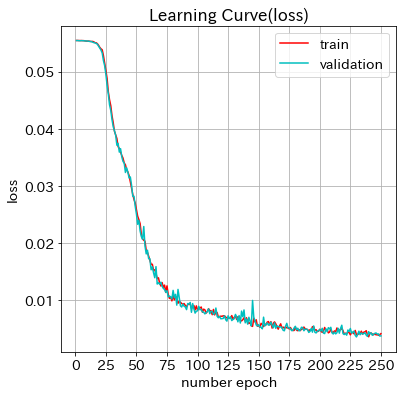

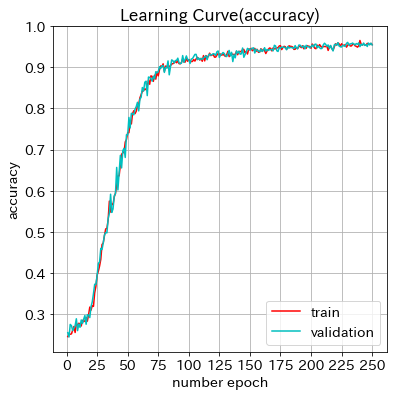

In [54]:
# ミニバッチのサイズ指定
batch_size = 25

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv1d(batch_size, 25, 5)
    self.conv2 = nn.Conv1d(25, batch_size, 5)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool1d(5)
    #self.flatten = nn.Flatten()
    self.l1 = nn.Linear(3998, 512)
    self.l2 = nn.Linear(512, n_output)
    
    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x = ( self.features(x.float()) ).float()
    #x = self.flatten(x)
    x = self.classifier(x)
    return x

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# モデルの概要表示
print(net)

# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 250

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history2)

# 評価
evaluate_history(history2)

# 畳こみをなくす　→　精度が大幅に向上なんで？？

torch.Size([25, 20000])
CNN(
  (maxpool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (l1): Linear(in_features=4000, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=4, bias=True)
  (features): Sequential(
    (0): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4000, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.04296 acc: 0.36458 val_loss: 0.03955, val_acc: 0.63125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.03751 acc: 0.72625 val_loss: 0.03548, val_acc: 0.83792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.03354 acc: 0.83000 val_loss: 0.03155, val_acc: 0.79417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.02968 acc: 0.85292 val_loss: 0.02781, val_acc: 0.79625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.02612 acc: 0.85292 val_loss: 0.02446, val_acc: 0.87708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.02303 acc: 0.93250 val_loss: 0.02163, val_acc: 0.96958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.02041 acc: 0.97958 val_loss: 0.01921, val_acc: 0.99417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01817 acc: 0.99042 val_loss: 0.01715, val_acc: 0.99125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01625 acc: 0.99000 val_loss: 0.01535, val_acc: 0.98750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01457 acc: 0.98542 val_loss: 0.01379, val_acc: 0.98250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01312 acc: 0.98292 val_loss: 0.01244, val_acc: 0.97625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01186 acc: 0.97708 val_loss: 0.01128, val_acc: 0.97625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01075 acc: 0.97583 val_loss: 0.01024, val_acc: 0.97542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00979 acc: 0.97625 val_loss: 0.00934, val_acc: 0.97625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00895 acc: 0.97667 val_loss: 0.00855, val_acc: 0.97917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00821 acc: 0.97917 val_loss: 0.00785, val_acc: 0.97833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00757 acc: 0.97833 val_loss: 0.00725, val_acc: 0.98083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00700 acc: 0.98083 val_loss: 0.00672, val_acc: 0.98083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00649 acc: 0.98083 val_loss: 0.00625, val_acc: 0.98167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00605 acc: 0.98208 val_loss: 0.00583, val_acc: 0.98250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00566 acc: 0.98333 val_loss: 0.00546, val_acc: 0.98417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00530 acc: 0.98542 val_loss: 0.00513, val_acc: 0.98542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00499 acc: 0.98542 val_loss: 0.00483, val_acc: 0.98625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00470 acc: 0.98625 val_loss: 0.00457, val_acc: 0.98625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00445 acc: 0.98667 val_loss: 0.00433, val_acc: 0.98625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00422 acc: 0.98667 val_loss: 0.00410, val_acc: 0.98708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00402 acc: 0.98750 val_loss: 0.00391, val_acc: 0.98792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00382 acc: 0.98792 val_loss: 0.00372, val_acc: 0.98792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00365 acc: 0.98833 val_loss: 0.00355, val_acc: 0.98875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00348 acc: 0.98833 val_loss: 0.00339, val_acc: 0.98875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00333 acc: 0.98875 val_loss: 0.00325, val_acc: 0.98833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00320 acc: 0.98833 val_loss: 0.00312, val_acc: 0.98875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00307 acc: 0.98917 val_loss: 0.00300, val_acc: 0.98875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00295 acc: 0.98917 val_loss: 0.00289, val_acc: 0.98958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00284 acc: 0.98917 val_loss: 0.00278, val_acc: 0.99083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00274 acc: 0.99083 val_loss: 0.00268, val_acc: 0.99125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00265 acc: 0.99167 val_loss: 0.00259, val_acc: 0.99125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00256 acc: 0.99167 val_loss: 0.00251, val_acc: 0.99292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00248 acc: 0.99208 val_loss: 0.00242, val_acc: 0.99292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00240 acc: 0.99333 val_loss: 0.00235, val_acc: 0.99333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00232 acc: 0.99333 val_loss: 0.00228, val_acc: 0.99417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00226 acc: 0.99417 val_loss: 0.00221, val_acc: 0.99417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00219 acc: 0.99417 val_loss: 0.00214, val_acc: 0.99458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00213 acc: 0.99417 val_loss: 0.00209, val_acc: 0.99500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00207 acc: 0.99500 val_loss: 0.00203, val_acc: 0.99458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00201 acc: 0.99458 val_loss: 0.00197, val_acc: 0.99500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00196 acc: 0.99542 val_loss: 0.00193, val_acc: 0.99583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00191 acc: 0.99542 val_loss: 0.00187, val_acc: 0.99583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00186 acc: 0.99583 val_loss: 0.00183, val_acc: 0.99542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00181 acc: 0.99583 val_loss: 0.00178, val_acc: 0.99542
初期状態: 損失: 0.03955 精度: 0.63125
最終状態: 損失: 0.00178 精度: 0.99542


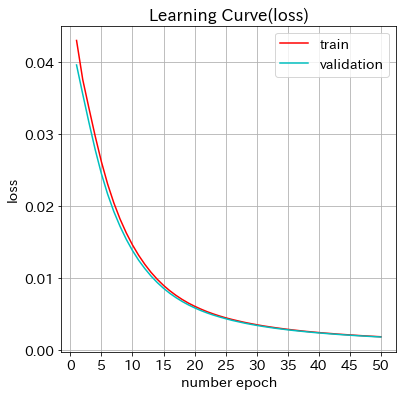

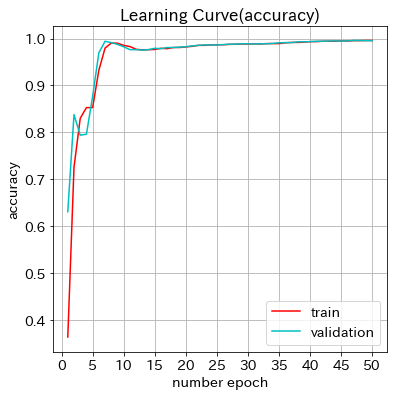

In [114]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 25

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.maxpool = nn.MaxPool1d(5)
    self.relu = nn.ReLU(inplace=True)
    self.l1 = nn.Linear(4000, 512)
    self.l2 = nn.Linear(512, n_output)
    
    self.features = nn.Sequential(
        
        self.maxpool)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x = ( self.features(x.float()) ).float()
    x = self.classifier(x)
    return x

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# モデルの概要表示
print(net)

# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history2)

# 評価
evaluate_history(history2)

In [86]:
# Maxpoolにもなくす

torch.Size([25, 20000])
CNN(
  (relu): ReLU(inplace=True)
  (l1): Linear(in_features=20000, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=4, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [1/250], loss: 0.04218 acc: 0.57708 val_loss: 0.03751, val_acc: 0.83000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [2/250], loss: 0.03451 acc: 0.88292 val_loss: 0.03152, val_acc: 0.93500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [3/250], loss: 0.02882 acc: 0.96292 val_loss: 0.02613, val_acc: 0.97500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [4/250], loss: 0.02383 acc: 0.97792 val_loss: 0.02158, val_acc: 0.98542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [5/250], loss: 0.01970 acc: 0.98042 val_loss: 0.01789, val_acc: 0.97583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [6/250], loss: 0.01643 acc: 0.97458 val_loss: 0.01496, val_acc: 0.97417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [7/250], loss: 0.01380 acc: 0.97333 val_loss: 0.01268, val_acc: 0.97292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [8/250], loss: 0.01177 acc: 0.97208 val_loss: 0.01085, val_acc: 0.97250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [9/250], loss: 0.01015 acc: 0.97375 val_loss: 0.00943, val_acc: 0.97375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [10/250], loss: 0.00887 acc: 0.97500 val_loss: 0.00829, val_acc: 0.97792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [11/250], loss: 0.00785 acc: 0.97833 val_loss: 0.00737, val_acc: 0.98083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [12/250], loss: 0.00702 acc: 0.98083 val_loss: 0.00664, val_acc: 0.98083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [13/250], loss: 0.00634 acc: 0.98125 val_loss: 0.00600, val_acc: 0.98125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [14/250], loss: 0.00576 acc: 0.98208 val_loss: 0.00547, val_acc: 0.98208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [15/250], loss: 0.00529 acc: 0.98250 val_loss: 0.00504, val_acc: 0.98333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [16/250], loss: 0.00486 acc: 0.98542 val_loss: 0.00467, val_acc: 0.98542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [17/250], loss: 0.00452 acc: 0.98667 val_loss: 0.00436, val_acc: 0.98625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [18/250], loss: 0.00424 acc: 0.98625 val_loss: 0.00406, val_acc: 0.98708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [19/250], loss: 0.00395 acc: 0.98750 val_loss: 0.00384, val_acc: 0.98875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [20/250], loss: 0.00374 acc: 0.98917 val_loss: 0.00358, val_acc: 0.98958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [21/250], loss: 0.00352 acc: 0.98958 val_loss: 0.00340, val_acc: 0.99167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [22/250], loss: 0.00335 acc: 0.99083 val_loss: 0.00322, val_acc: 0.99208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [23/250], loss: 0.00317 acc: 0.99125 val_loss: 0.00308, val_acc: 0.99167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [24/250], loss: 0.00303 acc: 0.99167 val_loss: 0.00291, val_acc: 0.99250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [25/250], loss: 0.00286 acc: 0.99208 val_loss: 0.00278, val_acc: 0.99250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [26/250], loss: 0.00273 acc: 0.99125 val_loss: 0.00267, val_acc: 0.99292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [27/250], loss: 0.00264 acc: 0.99208 val_loss: 0.00255, val_acc: 0.99292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [28/250], loss: 0.00253 acc: 0.99250 val_loss: 0.00244, val_acc: 0.99333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [29/250], loss: 0.00242 acc: 0.99333 val_loss: 0.00237, val_acc: 0.99417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [30/250], loss: 0.00235 acc: 0.99375 val_loss: 0.00227, val_acc: 0.99417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [31/250], loss: 0.00225 acc: 0.99417 val_loss: 0.00218, val_acc: 0.99375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [32/250], loss: 0.00217 acc: 0.99458 val_loss: 0.00211, val_acc: 0.99500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [33/250], loss: 0.00210 acc: 0.99458 val_loss: 0.00203, val_acc: 0.99500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [34/250], loss: 0.00203 acc: 0.99458 val_loss: 0.00197, val_acc: 0.99500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [35/250], loss: 0.00196 acc: 0.99583 val_loss: 0.00191, val_acc: 0.99583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [36/250], loss: 0.00190 acc: 0.99542 val_loss: 0.00185, val_acc: 0.99708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [37/250], loss: 0.00185 acc: 0.99667 val_loss: 0.00180, val_acc: 0.99708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [38/250], loss: 0.00179 acc: 0.99708 val_loss: 0.00174, val_acc: 0.99708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [39/250], loss: 0.00174 acc: 0.99583 val_loss: 0.00170, val_acc: 0.99708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [40/250], loss: 0.00169 acc: 0.99625 val_loss: 0.00165, val_acc: 0.99750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [41/250], loss: 0.00165 acc: 0.99667 val_loss: 0.00160, val_acc: 0.99750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [42/250], loss: 0.00159 acc: 0.99750 val_loss: 0.00158, val_acc: 0.99708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [43/250], loss: 0.00156 acc: 0.99750 val_loss: 0.00154, val_acc: 0.99750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [44/250], loss: 0.00152 acc: 0.99792 val_loss: 0.00148, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [45/250], loss: 0.00148 acc: 0.99833 val_loss: 0.00145, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [46/250], loss: 0.00145 acc: 0.99833 val_loss: 0.00142, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [47/250], loss: 0.00141 acc: 0.99833 val_loss: 0.00138, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [48/250], loss: 0.00138 acc: 0.99833 val_loss: 0.00135, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [49/250], loss: 0.00135 acc: 0.99833 val_loss: 0.00132, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [50/250], loss: 0.00132 acc: 0.99792 val_loss: 0.00129, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [51/250], loss: 0.00129 acc: 0.99833 val_loss: 0.00126, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [52/250], loss: 0.00126 acc: 0.99875 val_loss: 0.00124, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [53/250], loss: 0.00124 acc: 0.99833 val_loss: 0.00121, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [54/250], loss: 0.00122 acc: 0.99875 val_loss: 0.00119, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [55/250], loss: 0.00119 acc: 0.99875 val_loss: 0.00116, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [56/250], loss: 0.00117 acc: 0.99833 val_loss: 0.00114, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [57/250], loss: 0.00114 acc: 0.99875 val_loss: 0.00113, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [58/250], loss: 0.00112 acc: 0.99833 val_loss: 0.00112, val_acc: 0.99833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [59/250], loss: 0.00110 acc: 0.99875 val_loss: 0.00108, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [60/250], loss: 0.00108 acc: 0.99875 val_loss: 0.00106, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [61/250], loss: 0.00106 acc: 0.99875 val_loss: 0.00105, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [62/250], loss: 0.00104 acc: 0.99875 val_loss: 0.00102, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [63/250], loss: 0.00102 acc: 0.99875 val_loss: 0.00101, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [64/250], loss: 0.00100 acc: 0.99875 val_loss: 0.00098, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [65/250], loss: 0.00099 acc: 0.99875 val_loss: 0.00098, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [66/250], loss: 0.00097 acc: 0.99875 val_loss: 0.00095, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [67/250], loss: 0.00095 acc: 0.99875 val_loss: 0.00094, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [68/250], loss: 0.00094 acc: 0.99875 val_loss: 0.00092, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [69/250], loss: 0.00093 acc: 0.99875 val_loss: 0.00091, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [70/250], loss: 0.00091 acc: 0.99875 val_loss: 0.00089, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [71/250], loss: 0.00089 acc: 0.99875 val_loss: 0.00088, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [72/250], loss: 0.00088 acc: 0.99875 val_loss: 0.00086, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [73/250], loss: 0.00086 acc: 0.99875 val_loss: 0.00085, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [74/250], loss: 0.00085 acc: 0.99875 val_loss: 0.00084, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [75/250], loss: 0.00084 acc: 0.99875 val_loss: 0.00083, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [76/250], loss: 0.00083 acc: 0.99875 val_loss: 0.00081, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [77/250], loss: 0.00081 acc: 0.99875 val_loss: 0.00080, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [78/250], loss: 0.00080 acc: 0.99875 val_loss: 0.00079, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [79/250], loss: 0.00079 acc: 0.99875 val_loss: 0.00078, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [80/250], loss: 0.00078 acc: 0.99875 val_loss: 0.00077, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [81/250], loss: 0.00077 acc: 0.99875 val_loss: 0.00075, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [82/250], loss: 0.00076 acc: 0.99875 val_loss: 0.00074, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [83/250], loss: 0.00075 acc: 0.99875 val_loss: 0.00073, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [84/250], loss: 0.00074 acc: 0.99875 val_loss: 0.00073, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [85/250], loss: 0.00073 acc: 0.99875 val_loss: 0.00072, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [86/250], loss: 0.00072 acc: 0.99875 val_loss: 0.00070, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [87/250], loss: 0.00071 acc: 0.99875 val_loss: 0.00070, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [88/250], loss: 0.00070 acc: 0.99875 val_loss: 0.00069, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [89/250], loss: 0.00069 acc: 0.99875 val_loss: 0.00068, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [90/250], loss: 0.00068 acc: 0.99875 val_loss: 0.00067, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [91/250], loss: 0.00067 acc: 0.99875 val_loss: 0.00066, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [92/250], loss: 0.00066 acc: 0.99875 val_loss: 0.00065, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [93/250], loss: 0.00065 acc: 0.99875 val_loss: 0.00065, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [94/250], loss: 0.00065 acc: 0.99875 val_loss: 0.00064, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [95/250], loss: 0.00064 acc: 0.99875 val_loss: 0.00063, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [96/250], loss: 0.00063 acc: 0.99875 val_loss: 0.00062, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [97/250], loss: 0.00062 acc: 0.99875 val_loss: 0.00061, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [98/250], loss: 0.00062 acc: 0.99875 val_loss: 0.00061, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [99/250], loss: 0.00061 acc: 0.99875 val_loss: 0.00060, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [100/250], loss: 0.00060 acc: 0.99875 val_loss: 0.00059, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [101/250], loss: 0.00059 acc: 0.99875 val_loss: 0.00058, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [102/250], loss: 0.00059 acc: 0.99875 val_loss: 0.00058, val_acc: 0.99875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [103/250], loss: 0.00058 acc: 0.99875 val_loss: 0.00058, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [104/250], loss: 0.00057 acc: 0.99875 val_loss: 0.00057, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [105/250], loss: 0.00057 acc: 0.99875 val_loss: 0.00056, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [106/250], loss: 0.00056 acc: 0.99917 val_loss: 0.00055, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [107/250], loss: 0.00056 acc: 0.99875 val_loss: 0.00055, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [108/250], loss: 0.00055 acc: 0.99875 val_loss: 0.00054, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [109/250], loss: 0.00054 acc: 0.99875 val_loss: 0.00054, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [110/250], loss: 0.00054 acc: 0.99917 val_loss: 0.00053, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [111/250], loss: 0.00053 acc: 0.99917 val_loss: 0.00052, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [112/250], loss: 0.00053 acc: 0.99917 val_loss: 0.00052, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [113/250], loss: 0.00052 acc: 0.99917 val_loss: 0.00051, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [114/250], loss: 0.00051 acc: 0.99917 val_loss: 0.00051, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [115/250], loss: 0.00051 acc: 0.99917 val_loss: 0.00050, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [116/250], loss: 0.00050 acc: 0.99917 val_loss: 0.00050, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [117/250], loss: 0.00050 acc: 0.99958 val_loss: 0.00049, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [118/250], loss: 0.00049 acc: 0.99958 val_loss: 0.00049, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [119/250], loss: 0.00049 acc: 0.99958 val_loss: 0.00048, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [120/250], loss: 0.00048 acc: 0.99917 val_loss: 0.00048, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [121/250], loss: 0.00048 acc: 0.99917 val_loss: 0.00047, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [122/250], loss: 0.00047 acc: 0.99958 val_loss: 0.00047, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [123/250], loss: 0.00047 acc: 0.99917 val_loss: 0.00046, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [124/250], loss: 0.00046 acc: 0.99958 val_loss: 0.00046, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [125/250], loss: 0.00046 acc: 0.99958 val_loss: 0.00046, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [126/250], loss: 0.00046 acc: 0.99958 val_loss: 0.00045, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [127/250], loss: 0.00045 acc: 0.99958 val_loss: 0.00045, val_acc: 0.99917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [128/250], loss: 0.00045 acc: 0.99917 val_loss: 0.00044, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [129/250], loss: 0.00044 acc: 0.99958 val_loss: 0.00044, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [130/250], loss: 0.00044 acc: 0.99958 val_loss: 0.00043, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [131/250], loss: 0.00044 acc: 0.99958 val_loss: 0.00043, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [132/250], loss: 0.00043 acc: 0.99958 val_loss: 0.00043, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [133/250], loss: 0.00043 acc: 1.00000 val_loss: 0.00042, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [134/250], loss: 0.00042 acc: 0.99958 val_loss: 0.00042, val_acc: 0.99958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [135/250], loss: 0.00042 acc: 0.99958 val_loss: 0.00041, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [136/250], loss: 0.00042 acc: 0.99958 val_loss: 0.00041, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [137/250], loss: 0.00041 acc: 1.00000 val_loss: 0.00041, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [138/250], loss: 0.00041 acc: 0.99958 val_loss: 0.00040, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [139/250], loss: 0.00040 acc: 1.00000 val_loss: 0.00040, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [140/250], loss: 0.00040 acc: 1.00000 val_loss: 0.00040, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [141/250], loss: 0.00040 acc: 1.00000 val_loss: 0.00039, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [142/250], loss: 0.00039 acc: 1.00000 val_loss: 0.00039, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [143/250], loss: 0.00039 acc: 1.00000 val_loss: 0.00039, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [144/250], loss: 0.00039 acc: 1.00000 val_loss: 0.00038, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [145/250], loss: 0.00038 acc: 1.00000 val_loss: 0.00038, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [146/250], loss: 0.00038 acc: 1.00000 val_loss: 0.00038, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [147/250], loss: 0.00038 acc: 1.00000 val_loss: 0.00038, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [148/250], loss: 0.00038 acc: 1.00000 val_loss: 0.00037, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [149/250], loss: 0.00037 acc: 1.00000 val_loss: 0.00037, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [150/250], loss: 0.00037 acc: 1.00000 val_loss: 0.00036, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [151/250], loss: 0.00037 acc: 1.00000 val_loss: 0.00036, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [152/250], loss: 0.00036 acc: 1.00000 val_loss: 0.00036, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [153/250], loss: 0.00036 acc: 1.00000 val_loss: 0.00036, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [154/250], loss: 0.00036 acc: 1.00000 val_loss: 0.00035, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [155/250], loss: 0.00035 acc: 1.00000 val_loss: 0.00035, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [156/250], loss: 0.00035 acc: 1.00000 val_loss: 0.00035, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [157/250], loss: 0.00035 acc: 1.00000 val_loss: 0.00034, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [158/250], loss: 0.00035 acc: 1.00000 val_loss: 0.00034, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [159/250], loss: 0.00034 acc: 1.00000 val_loss: 0.00034, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [160/250], loss: 0.00034 acc: 1.00000 val_loss: 0.00034, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [161/250], loss: 0.00034 acc: 1.00000 val_loss: 0.00034, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [162/250], loss: 0.00034 acc: 1.00000 val_loss: 0.00033, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [163/250], loss: 0.00033 acc: 1.00000 val_loss: 0.00033, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [164/250], loss: 0.00033 acc: 1.00000 val_loss: 0.00033, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [165/250], loss: 0.00033 acc: 1.00000 val_loss: 0.00033, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [166/250], loss: 0.00033 acc: 1.00000 val_loss: 0.00032, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [167/250], loss: 0.00032 acc: 1.00000 val_loss: 0.00032, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [168/250], loss: 0.00032 acc: 1.00000 val_loss: 0.00032, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [169/250], loss: 0.00032 acc: 1.00000 val_loss: 0.00032, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [170/250], loss: 0.00032 acc: 1.00000 val_loss: 0.00031, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [171/250], loss: 0.00031 acc: 1.00000 val_loss: 0.00031, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [172/250], loss: 0.00031 acc: 1.00000 val_loss: 0.00031, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [173/250], loss: 0.00031 acc: 1.00000 val_loss: 0.00031, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [174/250], loss: 0.00031 acc: 1.00000 val_loss: 0.00030, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [175/250], loss: 0.00031 acc: 1.00000 val_loss: 0.00030, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [176/250], loss: 0.00030 acc: 1.00000 val_loss: 0.00030, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [177/250], loss: 0.00030 acc: 1.00000 val_loss: 0.00030, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [178/250], loss: 0.00030 acc: 1.00000 val_loss: 0.00030, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [179/250], loss: 0.00030 acc: 1.00000 val_loss: 0.00029, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [180/250], loss: 0.00030 acc: 1.00000 val_loss: 0.00029, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [181/250], loss: 0.00029 acc: 1.00000 val_loss: 0.00029, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [182/250], loss: 0.00029 acc: 1.00000 val_loss: 0.00029, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [183/250], loss: 0.00029 acc: 1.00000 val_loss: 0.00029, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [184/250], loss: 0.00029 acc: 1.00000 val_loss: 0.00028, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [185/250], loss: 0.00029 acc: 1.00000 val_loss: 0.00028, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [186/250], loss: 0.00028 acc: 1.00000 val_loss: 0.00028, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [187/250], loss: 0.00028 acc: 1.00000 val_loss: 0.00028, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [188/250], loss: 0.00028 acc: 1.00000 val_loss: 0.00028, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [189/250], loss: 0.00028 acc: 1.00000 val_loss: 0.00027, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [190/250], loss: 0.00028 acc: 1.00000 val_loss: 0.00027, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [191/250], loss: 0.00027 acc: 1.00000 val_loss: 0.00027, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [192/250], loss: 0.00027 acc: 1.00000 val_loss: 0.00027, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [193/250], loss: 0.00027 acc: 1.00000 val_loss: 0.00027, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [194/250], loss: 0.00027 acc: 1.00000 val_loss: 0.00027, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [195/250], loss: 0.00027 acc: 1.00000 val_loss: 0.00026, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [196/250], loss: 0.00027 acc: 1.00000 val_loss: 0.00026, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [197/250], loss: 0.00026 acc: 1.00000 val_loss: 0.00026, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [198/250], loss: 0.00026 acc: 1.00000 val_loss: 0.00026, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [199/250], loss: 0.00026 acc: 1.00000 val_loss: 0.00026, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [200/250], loss: 0.00026 acc: 1.00000 val_loss: 0.00026, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [201/250], loss: 0.00026 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [202/250], loss: 0.00026 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [203/250], loss: 0.00025 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [204/250], loss: 0.00025 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [205/250], loss: 0.00025 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [206/250], loss: 0.00025 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [207/250], loss: 0.00025 acc: 1.00000 val_loss: 0.00025, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [208/250], loss: 0.00025 acc: 1.00000 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [209/250], loss: 0.00025 acc: 1.00000 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [210/250], loss: 0.00024 acc: 1.00000 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [211/250], loss: 0.00024 acc: 1.00000 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [212/250], loss: 0.00024 acc: 1.00000 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [213/250], loss: 0.00024 acc: 1.00000 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [214/250], loss: 0.00024 acc: 1.00000 val_loss: 0.00024, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [215/250], loss: 0.00024 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [216/250], loss: 0.00024 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [217/250], loss: 0.00023 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [218/250], loss: 0.00023 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [219/250], loss: 0.00023 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [220/250], loss: 0.00023 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [221/250], loss: 0.00023 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [222/250], loss: 0.00023 acc: 1.00000 val_loss: 0.00023, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [223/250], loss: 0.00023 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [224/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [225/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [226/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [227/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [228/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [229/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [230/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00022, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [231/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [232/250], loss: 0.00022 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [233/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [234/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [235/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [236/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [237/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [238/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [239/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00021, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [240/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [241/250], loss: 0.00021 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [242/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [243/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [244/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [245/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [246/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [247/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [248/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [249/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00020, val_acc: 1.00000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [250/250], loss: 0.00020 acc: 1.00000 val_loss: 0.00019, val_acc: 1.00000
初期状態: 損失: 0.03751 精度: 0.83000
最終状態: 損失: 0.00019 精度: 1.00000


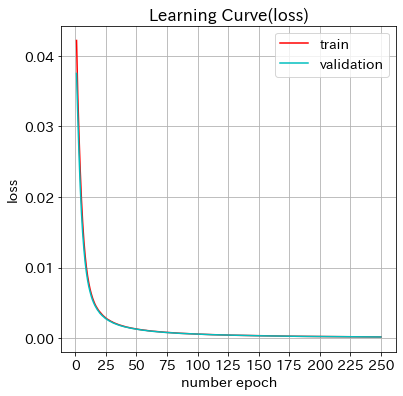

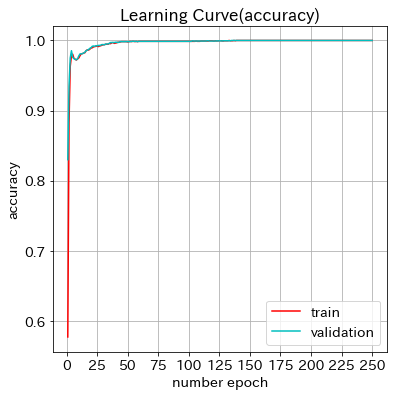

In [116]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 25

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.relu = nn.ReLU(inplace=True)
    self.l1 = nn.Linear(20000, 512)
    self.l2 = nn.Linear(512, n_output)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x = self.classifier(x)
    return x

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# モデルの概要表示
print(net)

# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 250

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history2)

# 評価
evaluate_history(history2)

# 畳こみのカーネルサイズを３にする→カーネルサイズ５より向上

torch.Size([25, 20000])
CNN(
  (conv1): Conv1d(25, 25, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(25, 25, kernel_size=(3,), stride=(1,))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=3999, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=4, bias=True)
  (features): Sequential(
    (0): Conv1d(25, 25, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(25, 25, kernel_size=(3,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3999, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [1/250], loss: 0.05547 acc: 0.24917 val_loss: 0.05546, val_acc: 0.25500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [2/250], loss: 0.05547 acc: 0.24500 val_loss: 0.05545, val_acc: 0.25500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [3/250], loss: 0.05546 acc: 0.23958 val_loss: 0.05544, val_acc: 0.25625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [4/250], loss: 0.05544 acc: 0.25792 val_loss: 0.05544, val_acc: 0.25042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [5/250], loss: 0.05545 acc: 0.25833 val_loss: 0.05544, val_acc: 0.25708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [6/250], loss: 0.05545 acc: 0.25083 val_loss: 0.05544, val_acc: 0.26167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [7/250], loss: 0.05547 acc: 0.25042 val_loss: 0.05546, val_acc: 0.24708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [8/250], loss: 0.05546 acc: 0.24458 val_loss: 0.05544, val_acc: 0.25833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [9/250], loss: 0.05544 acc: 0.24708 val_loss: 0.05546, val_acc: 0.25833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [10/250], loss: 0.05545 acc: 0.25042 val_loss: 0.05546, val_acc: 0.26375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [11/250], loss: 0.05545 acc: 0.25417 val_loss: 0.05544, val_acc: 0.25583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [12/250], loss: 0.05547 acc: 0.25375 val_loss: 0.05544, val_acc: 0.26750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [13/250], loss: 0.05546 acc: 0.26042 val_loss: 0.05543, val_acc: 0.27292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [14/250], loss: 0.05545 acc: 0.26208 val_loss: 0.05544, val_acc: 0.25167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [15/250], loss: 0.05544 acc: 0.26250 val_loss: 0.05543, val_acc: 0.25625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [16/250], loss: 0.05545 acc: 0.25417 val_loss: 0.05543, val_acc: 0.26583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [17/250], loss: 0.05545 acc: 0.25583 val_loss: 0.05544, val_acc: 0.26458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [18/250], loss: 0.05543 acc: 0.26250 val_loss: 0.05545, val_acc: 0.25208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [19/250], loss: 0.05546 acc: 0.24875 val_loss: 0.05545, val_acc: 0.25083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [20/250], loss: 0.05545 acc: 0.24583 val_loss: 0.05543, val_acc: 0.26625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [21/250], loss: 0.05544 acc: 0.25417 val_loss: 0.05543, val_acc: 0.26583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [22/250], loss: 0.05543 acc: 0.27375 val_loss: 0.05542, val_acc: 0.27292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [23/250], loss: 0.05544 acc: 0.25000 val_loss: 0.05544, val_acc: 0.25917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [24/250], loss: 0.05543 acc: 0.24833 val_loss: 0.05543, val_acc: 0.26042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [25/250], loss: 0.05542 acc: 0.26833 val_loss: 0.05543, val_acc: 0.27000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [26/250], loss: 0.05540 acc: 0.25917 val_loss: 0.05540, val_acc: 0.26208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [27/250], loss: 0.05543 acc: 0.26250 val_loss: 0.05540, val_acc: 0.27667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [28/250], loss: 0.05540 acc: 0.27125 val_loss: 0.05539, val_acc: 0.27750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [29/250], loss: 0.05538 acc: 0.26417 val_loss: 0.05540, val_acc: 0.26917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [30/250], loss: 0.05542 acc: 0.26042 val_loss: 0.05543, val_acc: 0.24875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [31/250], loss: 0.05539 acc: 0.25917 val_loss: 0.05541, val_acc: 0.25833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [32/250], loss: 0.05539 acc: 0.26583 val_loss: 0.05533, val_acc: 0.27542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [33/250], loss: 0.05535 acc: 0.27417 val_loss: 0.05531, val_acc: 0.27167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [34/250], loss: 0.05535 acc: 0.26000 val_loss: 0.05526, val_acc: 0.28417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [35/250], loss: 0.05531 acc: 0.26833 val_loss: 0.05529, val_acc: 0.27500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [36/250], loss: 0.05528 acc: 0.27000 val_loss: 0.05523, val_acc: 0.27542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [37/250], loss: 0.05525 acc: 0.28167 val_loss: 0.05523, val_acc: 0.27708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [38/250], loss: 0.05522 acc: 0.28750 val_loss: 0.05519, val_acc: 0.28125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [39/250], loss: 0.05517 acc: 0.28083 val_loss: 0.05513, val_acc: 0.27750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [40/250], loss: 0.05515 acc: 0.28208 val_loss: 0.05505, val_acc: 0.29208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [41/250], loss: 0.05504 acc: 0.28875 val_loss: 0.05490, val_acc: 0.28958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [42/250], loss: 0.05497 acc: 0.28625 val_loss: 0.05481, val_acc: 0.31417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [43/250], loss: 0.05476 acc: 0.29583 val_loss: 0.05467, val_acc: 0.30750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [44/250], loss: 0.05463 acc: 0.29167 val_loss: 0.05442, val_acc: 0.31417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [45/250], loss: 0.05419 acc: 0.32458 val_loss: 0.05407, val_acc: 0.32167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [46/250], loss: 0.05383 acc: 0.32833 val_loss: 0.05382, val_acc: 0.31917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [47/250], loss: 0.05334 acc: 0.33833 val_loss: 0.05366, val_acc: 0.32875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [48/250], loss: 0.05298 acc: 0.34542 val_loss: 0.05272, val_acc: 0.34750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [49/250], loss: 0.05216 acc: 0.35958 val_loss: 0.05154, val_acc: 0.36708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [50/250], loss: 0.05130 acc: 0.37750 val_loss: 0.05088, val_acc: 0.37167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [51/250], loss: 0.05052 acc: 0.37958 val_loss: 0.04954, val_acc: 0.39708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [52/250], loss: 0.04952 acc: 0.38792 val_loss: 0.04844, val_acc: 0.40917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [53/250], loss: 0.04817 acc: 0.41417 val_loss: 0.04691, val_acc: 0.42625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [54/250], loss: 0.04650 acc: 0.42625 val_loss: 0.04515, val_acc: 0.45542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [55/250], loss: 0.04547 acc: 0.42875 val_loss: 0.04436, val_acc: 0.45625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [56/250], loss: 0.04424 acc: 0.45750 val_loss: 0.04313, val_acc: 0.45292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [57/250], loss: 0.04288 acc: 0.46667 val_loss: 0.04256, val_acc: 0.46125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [58/250], loss: 0.04163 acc: 0.49792 val_loss: 0.04083, val_acc: 0.49375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [59/250], loss: 0.04058 acc: 0.49333 val_loss: 0.04014, val_acc: 0.50458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [60/250], loss: 0.03948 acc: 0.51458 val_loss: 0.03904, val_acc: 0.51292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [61/250], loss: 0.03863 acc: 0.50958 val_loss: 0.03825, val_acc: 0.52125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [62/250], loss: 0.03814 acc: 0.50083 val_loss: 0.03789, val_acc: 0.54042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [63/250], loss: 0.03730 acc: 0.53708 val_loss: 0.03693, val_acc: 0.52083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [64/250], loss: 0.03647 acc: 0.53458 val_loss: 0.03707, val_acc: 0.53083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [65/250], loss: 0.03624 acc: 0.55250 val_loss: 0.03622, val_acc: 0.53417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [66/250], loss: 0.03585 acc: 0.53917 val_loss: 0.03565, val_acc: 0.54875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [67/250], loss: 0.03534 acc: 0.55875 val_loss: 0.03461, val_acc: 0.55958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [68/250], loss: 0.03454 acc: 0.55833 val_loss: 0.03439, val_acc: 0.59375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [69/250], loss: 0.03450 acc: 0.55708 val_loss: 0.03416, val_acc: 0.55208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [70/250], loss: 0.03373 acc: 0.57458 val_loss: 0.03348, val_acc: 0.59208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [71/250], loss: 0.03358 acc: 0.57625 val_loss: 0.03345, val_acc: 0.59333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [72/250], loss: 0.03318 acc: 0.58667 val_loss: 0.03320, val_acc: 0.57042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [73/250], loss: 0.03275 acc: 0.58958 val_loss: 0.03271, val_acc: 0.61208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [74/250], loss: 0.03192 acc: 0.61458 val_loss: 0.03234, val_acc: 0.57750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [75/250], loss: 0.03222 acc: 0.61458 val_loss: 0.03145, val_acc: 0.62917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [76/250], loss: 0.03221 acc: 0.61750 val_loss: 0.03209, val_acc: 0.62208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [77/250], loss: 0.03089 acc: 0.62292 val_loss: 0.03117, val_acc: 0.58708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [78/250], loss: 0.03097 acc: 0.63375 val_loss: 0.03138, val_acc: 0.63792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [79/250], loss: 0.03094 acc: 0.63042 val_loss: 0.03067, val_acc: 0.65000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [80/250], loss: 0.03016 acc: 0.64542 val_loss: 0.02999, val_acc: 0.64083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [81/250], loss: 0.03015 acc: 0.64792 val_loss: 0.02997, val_acc: 0.67792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [82/250], loss: 0.02929 acc: 0.64375 val_loss: 0.02953, val_acc: 0.66292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [83/250], loss: 0.02863 acc: 0.67625 val_loss: 0.02880, val_acc: 0.65208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [84/250], loss: 0.02935 acc: 0.66292 val_loss: 0.02880, val_acc: 0.69125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [85/250], loss: 0.02751 acc: 0.70375 val_loss: 0.02729, val_acc: 0.68083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [86/250], loss: 0.02709 acc: 0.71500 val_loss: 0.02656, val_acc: 0.71375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [87/250], loss: 0.02638 acc: 0.72792 val_loss: 0.02620, val_acc: 0.71917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [88/250], loss: 0.02582 acc: 0.72542 val_loss: 0.02599, val_acc: 0.70833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [89/250], loss: 0.02553 acc: 0.72500 val_loss: 0.02519, val_acc: 0.73958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [90/250], loss: 0.02480 acc: 0.74417 val_loss: 0.02366, val_acc: 0.76042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [91/250], loss: 0.02365 acc: 0.76542 val_loss: 0.02284, val_acc: 0.76750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [92/250], loss: 0.02310 acc: 0.76458 val_loss: 0.02185, val_acc: 0.78042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [93/250], loss: 0.02209 acc: 0.78458 val_loss: 0.02252, val_acc: 0.76417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [94/250], loss: 0.02097 acc: 0.79542 val_loss: 0.02026, val_acc: 0.79708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [95/250], loss: 0.01966 acc: 0.80625 val_loss: 0.01893, val_acc: 0.83042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [96/250], loss: 0.01858 acc: 0.81333 val_loss: 0.01882, val_acc: 0.83292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [97/250], loss: 0.01804 acc: 0.82875 val_loss: 0.01796, val_acc: 0.83417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [98/250], loss: 0.01727 acc: 0.83625 val_loss: 0.01601, val_acc: 0.85000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [99/250], loss: 0.01654 acc: 0.84458 val_loss: 0.01587, val_acc: 0.85625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [100/250], loss: 0.01510 acc: 0.86375 val_loss: 0.01428, val_acc: 0.87333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [101/250], loss: 0.01435 acc: 0.87833 val_loss: 0.01438, val_acc: 0.88042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [102/250], loss: 0.01373 acc: 0.87417 val_loss: 0.01405, val_acc: 0.88708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [103/250], loss: 0.01273 acc: 0.89375 val_loss: 0.01234, val_acc: 0.89917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [104/250], loss: 0.01231 acc: 0.88833 val_loss: 0.01208, val_acc: 0.89375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [105/250], loss: 0.01191 acc: 0.89500 val_loss: 0.01165, val_acc: 0.90750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [106/250], loss: 0.01129 acc: 0.90500 val_loss: 0.01124, val_acc: 0.90125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [107/250], loss: 0.01080 acc: 0.90625 val_loss: 0.01066, val_acc: 0.90708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [108/250], loss: 0.01097 acc: 0.90417 val_loss: 0.01114, val_acc: 0.90792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [109/250], loss: 0.01014 acc: 0.91417 val_loss: 0.00882, val_acc: 0.92750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [110/250], loss: 0.00975 acc: 0.91958 val_loss: 0.01029, val_acc: 0.91792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [111/250], loss: 0.00968 acc: 0.91542 val_loss: 0.00876, val_acc: 0.92667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [112/250], loss: 0.00879 acc: 0.92458 val_loss: 0.00875, val_acc: 0.93042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [113/250], loss: 0.00879 acc: 0.92292 val_loss: 0.00972, val_acc: 0.91833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [114/250], loss: 0.00843 acc: 0.93333 val_loss: 0.00854, val_acc: 0.92792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [115/250], loss: 0.00789 acc: 0.93458 val_loss: 0.00795, val_acc: 0.93625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [116/250], loss: 0.00813 acc: 0.92875 val_loss: 0.00787, val_acc: 0.93417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [117/250], loss: 0.00794 acc: 0.93292 val_loss: 0.00742, val_acc: 0.94125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [118/250], loss: 0.00807 acc: 0.92708 val_loss: 0.00796, val_acc: 0.93083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [119/250], loss: 0.00766 acc: 0.94000 val_loss: 0.00742, val_acc: 0.93750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [120/250], loss: 0.00789 acc: 0.93250 val_loss: 0.00746, val_acc: 0.93667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [121/250], loss: 0.00721 acc: 0.93792 val_loss: 0.00639, val_acc: 0.95125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [122/250], loss: 0.00686 acc: 0.94542 val_loss: 0.00724, val_acc: 0.93292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [123/250], loss: 0.00693 acc: 0.93958 val_loss: 0.00701, val_acc: 0.94042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [124/250], loss: 0.00644 acc: 0.94750 val_loss: 0.00679, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [125/250], loss: 0.00655 acc: 0.94917 val_loss: 0.00747, val_acc: 0.93125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [126/250], loss: 0.00674 acc: 0.94125 val_loss: 0.00678, val_acc: 0.94208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [127/250], loss: 0.00677 acc: 0.93958 val_loss: 0.00752, val_acc: 0.93583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [128/250], loss: 0.00755 acc: 0.94125 val_loss: 0.00674, val_acc: 0.94083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [129/250], loss: 0.00619 acc: 0.95333 val_loss: 0.00587, val_acc: 0.95333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [130/250], loss: 0.00665 acc: 0.94125 val_loss: 0.00626, val_acc: 0.94833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [131/250], loss: 0.00643 acc: 0.94708 val_loss: 0.00573, val_acc: 0.94875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [132/250], loss: 0.00611 acc: 0.95292 val_loss: 0.00589, val_acc: 0.94500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [133/250], loss: 0.00549 acc: 0.95708 val_loss: 0.00554, val_acc: 0.95792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [134/250], loss: 0.00603 acc: 0.95458 val_loss: 0.00641, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [135/250], loss: 0.00617 acc: 0.94750 val_loss: 0.00619, val_acc: 0.95125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [136/250], loss: 0.00593 acc: 0.95292 val_loss: 0.00616, val_acc: 0.94250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [137/250], loss: 0.00603 acc: 0.95042 val_loss: 0.00515, val_acc: 0.96167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [138/250], loss: 0.00656 acc: 0.94917 val_loss: 0.00637, val_acc: 0.94958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [139/250], loss: 0.00623 acc: 0.94833 val_loss: 0.00514, val_acc: 0.95917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [140/250], loss: 0.00547 acc: 0.95792 val_loss: 0.00756, val_acc: 0.93125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [141/250], loss: 0.00625 acc: 0.94667 val_loss: 0.00614, val_acc: 0.94167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [142/250], loss: 0.00585 acc: 0.95625 val_loss: 0.00608, val_acc: 0.94667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [143/250], loss: 0.00524 acc: 0.95542 val_loss: 0.00600, val_acc: 0.95167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [144/250], loss: 0.00631 acc: 0.94542 val_loss: 0.00552, val_acc: 0.95250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [145/250], loss: 0.00559 acc: 0.95125 val_loss: 0.00583, val_acc: 0.94917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [146/250], loss: 0.00531 acc: 0.95500 val_loss: 0.00514, val_acc: 0.96042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [147/250], loss: 0.00565 acc: 0.95458 val_loss: 0.00543, val_acc: 0.95667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [148/250], loss: 0.00556 acc: 0.95375 val_loss: 0.00507, val_acc: 0.95958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [149/250], loss: 0.00524 acc: 0.95250 val_loss: 0.00546, val_acc: 0.94917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [150/250], loss: 0.00568 acc: 0.95458 val_loss: 0.00664, val_acc: 0.94500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [151/250], loss: 0.00568 acc: 0.94625 val_loss: 0.00478, val_acc: 0.96250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [152/250], loss: 0.00469 acc: 0.96208 val_loss: 0.00495, val_acc: 0.95792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [153/250], loss: 0.00563 acc: 0.95292 val_loss: 0.00537, val_acc: 0.95958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [154/250], loss: 0.00498 acc: 0.95917 val_loss: 0.00490, val_acc: 0.95792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [155/250], loss: 0.00565 acc: 0.95417 val_loss: 0.00462, val_acc: 0.96292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [156/250], loss: 0.00499 acc: 0.95917 val_loss: 0.00480, val_acc: 0.96042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [157/250], loss: 0.00491 acc: 0.96000 val_loss: 0.00445, val_acc: 0.96542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [158/250], loss: 0.00489 acc: 0.95583 val_loss: 0.00539, val_acc: 0.95583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [159/250], loss: 0.00496 acc: 0.96042 val_loss: 0.00519, val_acc: 0.95417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [160/250], loss: 0.00511 acc: 0.95667 val_loss: 0.00490, val_acc: 0.95667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [161/250], loss: 0.00467 acc: 0.96208 val_loss: 0.00468, val_acc: 0.96208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [162/250], loss: 0.00513 acc: 0.95458 val_loss: 0.00502, val_acc: 0.96375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [163/250], loss: 0.00521 acc: 0.95583 val_loss: 0.00422, val_acc: 0.96667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [164/250], loss: 0.00496 acc: 0.95625 val_loss: 0.00450, val_acc: 0.96333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [165/250], loss: 0.00412 acc: 0.96625 val_loss: 0.00491, val_acc: 0.96000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [166/250], loss: 0.00547 acc: 0.95583 val_loss: 0.00426, val_acc: 0.96208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [167/250], loss: 0.00461 acc: 0.96083 val_loss: 0.00433, val_acc: 0.96750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [168/250], loss: 0.00382 acc: 0.97167 val_loss: 0.00428, val_acc: 0.96750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [169/250], loss: 0.00481 acc: 0.95708 val_loss: 0.00412, val_acc: 0.96833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [170/250], loss: 0.00474 acc: 0.96250 val_loss: 0.00554, val_acc: 0.94708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [171/250], loss: 0.00523 acc: 0.95083 val_loss: 0.00491, val_acc: 0.95583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [172/250], loss: 0.00465 acc: 0.96208 val_loss: 0.00563, val_acc: 0.95667


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [173/250], loss: 0.00462 acc: 0.96042 val_loss: 0.00390, val_acc: 0.96708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [174/250], loss: 0.00422 acc: 0.96417 val_loss: 0.00422, val_acc: 0.96958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [175/250], loss: 0.00484 acc: 0.96000 val_loss: 0.00394, val_acc: 0.96417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [176/250], loss: 0.00443 acc: 0.96000 val_loss: 0.00354, val_acc: 0.97250


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [177/250], loss: 0.00392 acc: 0.96542 val_loss: 0.00377, val_acc: 0.97042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [178/250], loss: 0.00434 acc: 0.96250 val_loss: 0.00368, val_acc: 0.97417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [179/250], loss: 0.00387 acc: 0.96833 val_loss: 0.00354, val_acc: 0.97333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [180/250], loss: 0.00371 acc: 0.97083 val_loss: 0.00510, val_acc: 0.95625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [181/250], loss: 0.00467 acc: 0.96083 val_loss: 0.00395, val_acc: 0.96333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [182/250], loss: 0.00380 acc: 0.97167 val_loss: 0.00334, val_acc: 0.97375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [183/250], loss: 0.00419 acc: 0.96625 val_loss: 0.00424, val_acc: 0.96417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [184/250], loss: 0.00422 acc: 0.96333 val_loss: 0.00361, val_acc: 0.97292


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [185/250], loss: 0.00307 acc: 0.97750 val_loss: 0.00341, val_acc: 0.97125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [186/250], loss: 0.00422 acc: 0.96875 val_loss: 0.00352, val_acc: 0.97333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [187/250], loss: 0.00354 acc: 0.97083 val_loss: 0.00338, val_acc: 0.97417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [188/250], loss: 0.00366 acc: 0.97333 val_loss: 0.00364, val_acc: 0.96875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [189/250], loss: 0.00399 acc: 0.96667 val_loss: 0.00314, val_acc: 0.97417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [190/250], loss: 0.00332 acc: 0.97458 val_loss: 0.00312, val_acc: 0.97083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [191/250], loss: 0.00361 acc: 0.96917 val_loss: 0.00321, val_acc: 0.97333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [192/250], loss: 0.00330 acc: 0.97333 val_loss: 0.00529, val_acc: 0.95542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [193/250], loss: 0.00403 acc: 0.96375 val_loss: 0.00496, val_acc: 0.94708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [194/250], loss: 0.00452 acc: 0.96333 val_loss: 0.00461, val_acc: 0.96167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [195/250], loss: 0.00460 acc: 0.96458 val_loss: 0.00363, val_acc: 0.97000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [196/250], loss: 0.00401 acc: 0.96792 val_loss: 0.00432, val_acc: 0.96458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [197/250], loss: 0.00325 acc: 0.97042 val_loss: 0.00312, val_acc: 0.97167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [198/250], loss: 0.00340 acc: 0.96917 val_loss: 0.00398, val_acc: 0.96750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [199/250], loss: 0.00366 acc: 0.97167 val_loss: 0.00385, val_acc: 0.96875


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [200/250], loss: 0.00388 acc: 0.96458 val_loss: 0.00400, val_acc: 0.96083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [201/250], loss: 0.00360 acc: 0.96917 val_loss: 0.00315, val_acc: 0.97208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [202/250], loss: 0.00365 acc: 0.96708 val_loss: 0.00302, val_acc: 0.97583


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [203/250], loss: 0.00394 acc: 0.96875 val_loss: 0.00360, val_acc: 0.97083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [204/250], loss: 0.00400 acc: 0.96208 val_loss: 0.00332, val_acc: 0.97333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [205/250], loss: 0.00344 acc: 0.97167 val_loss: 0.00308, val_acc: 0.97500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [206/250], loss: 0.00340 acc: 0.97792 val_loss: 0.00262, val_acc: 0.97917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [207/250], loss: 0.00333 acc: 0.97542 val_loss: 0.00262, val_acc: 0.98167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [208/250], loss: 0.00268 acc: 0.97833 val_loss: 0.00252, val_acc: 0.97917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [209/250], loss: 0.00403 acc: 0.96375 val_loss: 0.00400, val_acc: 0.95708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [210/250], loss: 0.00308 acc: 0.97500 val_loss: 0.00321, val_acc: 0.97542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [211/250], loss: 0.00381 acc: 0.96833 val_loss: 0.00295, val_acc: 0.97542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [212/250], loss: 0.00333 acc: 0.97125 val_loss: 0.00332, val_acc: 0.97417


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [213/250], loss: 0.00295 acc: 0.97708 val_loss: 0.00279, val_acc: 0.97625


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [214/250], loss: 0.00282 acc: 0.97625 val_loss: 0.00316, val_acc: 0.97458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [215/250], loss: 0.00353 acc: 0.96833 val_loss: 0.00254, val_acc: 0.97958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [216/250], loss: 0.00292 acc: 0.97750 val_loss: 0.00463, val_acc: 0.96750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [217/250], loss: 0.00319 acc: 0.97458 val_loss: 0.00226, val_acc: 0.98167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [218/250], loss: 0.00299 acc: 0.97542 val_loss: 0.00240, val_acc: 0.98208


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [219/250], loss: 0.00267 acc: 0.97750 val_loss: 0.00281, val_acc: 0.97792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [220/250], loss: 0.00307 acc: 0.97500 val_loss: 0.00286, val_acc: 0.97833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [221/250], loss: 0.00293 acc: 0.97417 val_loss: 0.00297, val_acc: 0.97500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [222/250], loss: 0.00278 acc: 0.97417 val_loss: 0.00244, val_acc: 0.98458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [223/250], loss: 0.00275 acc: 0.97833 val_loss: 0.00253, val_acc: 0.97708


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [224/250], loss: 0.00332 acc: 0.97167 val_loss: 0.00361, val_acc: 0.96833


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [225/250], loss: 0.00299 acc: 0.97583 val_loss: 0.00247, val_acc: 0.97792


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [226/250], loss: 0.00296 acc: 0.97792 val_loss: 0.00322, val_acc: 0.97500


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [227/250], loss: 0.00277 acc: 0.97750 val_loss: 0.00272, val_acc: 0.97750


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [228/250], loss: 0.00263 acc: 0.97917 val_loss: 0.00308, val_acc: 0.97542


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [229/250], loss: 0.00301 acc: 0.97458 val_loss: 0.00258, val_acc: 0.97958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [230/250], loss: 0.00255 acc: 0.97833 val_loss: 0.00229, val_acc: 0.98000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [231/250], loss: 0.00240 acc: 0.98125 val_loss: 0.00245, val_acc: 0.97917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [232/250], loss: 0.00293 acc: 0.97417 val_loss: 0.00285, val_acc: 0.97375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [233/250], loss: 0.00253 acc: 0.98083 val_loss: 0.00234, val_acc: 0.98083


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [234/250], loss: 0.00249 acc: 0.98042 val_loss: 0.00326, val_acc: 0.97000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [235/250], loss: 0.00251 acc: 0.97917 val_loss: 0.00219, val_acc: 0.98125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [236/250], loss: 0.00291 acc: 0.97750 val_loss: 0.00265, val_acc: 0.98042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [237/250], loss: 0.00234 acc: 0.97958 val_loss: 0.00190, val_acc: 0.98375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [238/250], loss: 0.00241 acc: 0.97708 val_loss: 0.00276, val_acc: 0.97958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [239/250], loss: 0.00250 acc: 0.97875 val_loss: 0.00241, val_acc: 0.98125


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [240/250], loss: 0.00359 acc: 0.96875 val_loss: 0.00348, val_acc: 0.96375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [241/250], loss: 0.00278 acc: 0.97917 val_loss: 0.00274, val_acc: 0.97917


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [242/250], loss: 0.00233 acc: 0.98333 val_loss: 0.00217, val_acc: 0.98458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [243/250], loss: 0.00242 acc: 0.98167 val_loss: 0.00248, val_acc: 0.98000


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [244/250], loss: 0.00224 acc: 0.97875 val_loss: 0.00281, val_acc: 0.98042


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [245/250], loss: 0.00246 acc: 0.98000 val_loss: 0.00197, val_acc: 0.98375


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [246/250], loss: 0.00263 acc: 0.97708 val_loss: 0.00253, val_acc: 0.97958


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [247/250], loss: 0.00270 acc: 0.97667 val_loss: 0.00282, val_acc: 0.97167


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [248/250], loss: 0.00246 acc: 0.97917 val_loss: 0.00211, val_acc: 0.98458


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [249/250], loss: 0.00237 acc: 0.98000 val_loss: 0.00374, val_acc: 0.96333


  0%|          | 0/96 [00:00<?, ?it/s]

Epoch [250/250], loss: 0.00266 acc: 0.97708 val_loss: 0.00203, val_acc: 0.98750
初期状態: 損失: 0.05546 精度: 0.25500
最終状態: 損失: 0.00203 精度: 0.98750


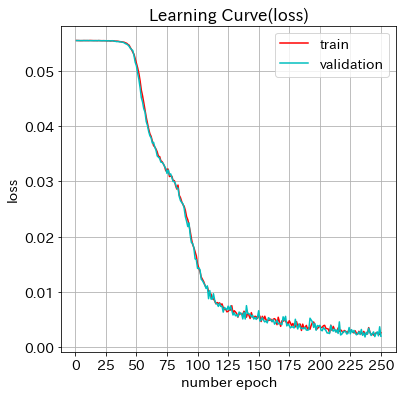

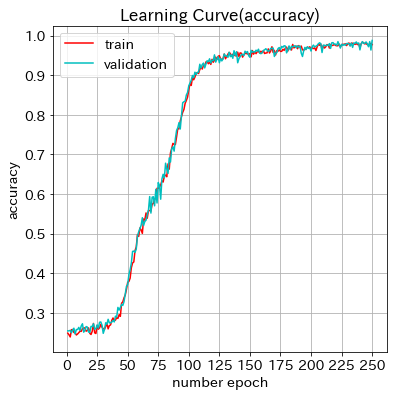

In [61]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 25

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv1d(batch_size, 25, 3)
    self.conv2 = nn.Conv1d(25, batch_size, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool1d(5)
    #self.flatten = nn.Flatten()
    self.l1 = nn.Linear(3999, 512)
    self.l2 = nn.Linear(512, n_output)
    
    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x = ( self.features(x.float()) ).float()
    #x = self.flatten(x)
    x = self.classifier(x)
    return x

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# モデルの概要表示
print(net)

# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 250

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history2)

# 評価
evaluate_history(history2)

# cov1とcovの間の出力チャンネルを減らす

torch.Size([50, 20000])
CNN(
  (conv1): Conv1d(50, 10, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(10, 50, kernel_size=(3,), stride=(1,))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=3999, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=4, bias=True)
  (features): Sequential(
    (0): Conv1d(50, 10, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(10, 50, kernel_size=(3,), stride=(1,))
    (3): ReLU(inplace=True)
    (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3999, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [1/250], loss: 0.02775 acc: 0.25250 val_loss: 0.02774, val_acc: 0.25542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [2/250], loss: 0.02775 acc: 0.26292 val_loss: 0.02775, val_acc: 0.24750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [3/250], loss: 0.02776 acc: 0.23417 val_loss: 0.02773, val_acc: 0.25542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [4/250], loss: 0.02774 acc: 0.24208 val_loss: 0.02773, val_acc: 0.25917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [5/250], loss: 0.02775 acc: 0.24792 val_loss: 0.02773, val_acc: 0.25958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [6/250], loss: 0.02774 acc: 0.25500 val_loss: 0.02772, val_acc: 0.25792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [7/250], loss: 0.02774 acc: 0.25000 val_loss: 0.02773, val_acc: 0.25250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [8/250], loss: 0.02773 acc: 0.24750 val_loss: 0.02771, val_acc: 0.24625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [9/250], loss: 0.02774 acc: 0.24250 val_loss: 0.02772, val_acc: 0.25250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [10/250], loss: 0.02773 acc: 0.25042 val_loss: 0.02771, val_acc: 0.25333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [11/250], loss: 0.02772 acc: 0.25083 val_loss: 0.02771, val_acc: 0.26500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [12/250], loss: 0.02772 acc: 0.26250 val_loss: 0.02773, val_acc: 0.24958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [13/250], loss: 0.02773 acc: 0.24750 val_loss: 0.02771, val_acc: 0.25042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [14/250], loss: 0.02774 acc: 0.24875 val_loss: 0.02772, val_acc: 0.25417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [15/250], loss: 0.02772 acc: 0.27000 val_loss: 0.02771, val_acc: 0.25792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [16/250], loss: 0.02772 acc: 0.25833 val_loss: 0.02771, val_acc: 0.25833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [17/250], loss: 0.02770 acc: 0.26375 val_loss: 0.02769, val_acc: 0.26792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [18/250], loss: 0.02771 acc: 0.25708 val_loss: 0.02766, val_acc: 0.28333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [19/250], loss: 0.02767 acc: 0.27792 val_loss: 0.02770, val_acc: 0.25792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [20/250], loss: 0.02770 acc: 0.25917 val_loss: 0.02767, val_acc: 0.28167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [21/250], loss: 0.02764 acc: 0.27750 val_loss: 0.02765, val_acc: 0.26667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [22/250], loss: 0.02769 acc: 0.25792 val_loss: 0.02759, val_acc: 0.27833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [23/250], loss: 0.02768 acc: 0.27417 val_loss: 0.02762, val_acc: 0.27250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [24/250], loss: 0.02767 acc: 0.26208 val_loss: 0.02756, val_acc: 0.27125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [25/250], loss: 0.02760 acc: 0.27042 val_loss: 0.02753, val_acc: 0.27625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [26/250], loss: 0.02757 acc: 0.28125 val_loss: 0.02749, val_acc: 0.30083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [27/250], loss: 0.02759 acc: 0.27667 val_loss: 0.02760, val_acc: 0.27292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [28/250], loss: 0.02752 acc: 0.28417 val_loss: 0.02749, val_acc: 0.28500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [29/250], loss: 0.02742 acc: 0.29542 val_loss: 0.02754, val_acc: 0.27792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [30/250], loss: 0.02745 acc: 0.28917 val_loss: 0.02739, val_acc: 0.29417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [31/250], loss: 0.02738 acc: 0.30042 val_loss: 0.02730, val_acc: 0.31292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [32/250], loss: 0.02729 acc: 0.29875 val_loss: 0.02718, val_acc: 0.30333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [33/250], loss: 0.02731 acc: 0.29833 val_loss: 0.02724, val_acc: 0.30458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [34/250], loss: 0.02700 acc: 0.31000 val_loss: 0.02709, val_acc: 0.30667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [35/250], loss: 0.02697 acc: 0.30167 val_loss: 0.02705, val_acc: 0.30625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [36/250], loss: 0.02700 acc: 0.32583 val_loss: 0.02690, val_acc: 0.30667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [37/250], loss: 0.02686 acc: 0.30875 val_loss: 0.02677, val_acc: 0.31667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [38/250], loss: 0.02677 acc: 0.31167 val_loss: 0.02676, val_acc: 0.32917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [39/250], loss: 0.02675 acc: 0.31583 val_loss: 0.02677, val_acc: 0.32167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [40/250], loss: 0.02657 acc: 0.34708 val_loss: 0.02651, val_acc: 0.32667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [41/250], loss: 0.02654 acc: 0.33542 val_loss: 0.02661, val_acc: 0.32542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [42/250], loss: 0.02614 acc: 0.34708 val_loss: 0.02626, val_acc: 0.34750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [43/250], loss: 0.02633 acc: 0.33625 val_loss: 0.02619, val_acc: 0.36000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [44/250], loss: 0.02609 acc: 0.34833 val_loss: 0.02603, val_acc: 0.35083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [45/250], loss: 0.02605 acc: 0.34833 val_loss: 0.02597, val_acc: 0.35292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [46/250], loss: 0.02572 acc: 0.35792 val_loss: 0.02592, val_acc: 0.35458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [47/250], loss: 0.02579 acc: 0.35333 val_loss: 0.02595, val_acc: 0.35792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [48/250], loss: 0.02575 acc: 0.36458 val_loss: 0.02582, val_acc: 0.35375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [49/250], loss: 0.02578 acc: 0.35292 val_loss: 0.02578, val_acc: 0.35167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [50/250], loss: 0.02568 acc: 0.35875 val_loss: 0.02565, val_acc: 0.35417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [51/250], loss: 0.02577 acc: 0.35792 val_loss: 0.02548, val_acc: 0.36375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [52/250], loss: 0.02571 acc: 0.36542 val_loss: 0.02563, val_acc: 0.35958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [53/250], loss: 0.02552 acc: 0.36083 val_loss: 0.02563, val_acc: 0.36833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [54/250], loss: 0.02538 acc: 0.37417 val_loss: 0.02540, val_acc: 0.35708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [55/250], loss: 0.02537 acc: 0.37833 val_loss: 0.02532, val_acc: 0.38292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [56/250], loss: 0.02526 acc: 0.37500 val_loss: 0.02517, val_acc: 0.38958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [57/250], loss: 0.02526 acc: 0.39917 val_loss: 0.02519, val_acc: 0.37833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [58/250], loss: 0.02526 acc: 0.36708 val_loss: 0.02539, val_acc: 0.38292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [59/250], loss: 0.02511 acc: 0.39458 val_loss: 0.02505, val_acc: 0.39250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [60/250], loss: 0.02476 acc: 0.39917 val_loss: 0.02482, val_acc: 0.39458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [61/250], loss: 0.02513 acc: 0.39208 val_loss: 0.02484, val_acc: 0.39792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [62/250], loss: 0.02504 acc: 0.39167 val_loss: 0.02460, val_acc: 0.39667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [63/250], loss: 0.02483 acc: 0.39583 val_loss: 0.02457, val_acc: 0.40292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [64/250], loss: 0.02481 acc: 0.38375 val_loss: 0.02463, val_acc: 0.40042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [65/250], loss: 0.02493 acc: 0.40708 val_loss: 0.02466, val_acc: 0.40458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [66/250], loss: 0.02466 acc: 0.38875 val_loss: 0.02426, val_acc: 0.42708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [67/250], loss: 0.02445 acc: 0.41458 val_loss: 0.02463, val_acc: 0.42292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [68/250], loss: 0.02459 acc: 0.40292 val_loss: 0.02444, val_acc: 0.41458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [69/250], loss: 0.02452 acc: 0.41333 val_loss: 0.02433, val_acc: 0.40333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [70/250], loss: 0.02437 acc: 0.41542 val_loss: 0.02449, val_acc: 0.40250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [71/250], loss: 0.02470 acc: 0.41167 val_loss: 0.02417, val_acc: 0.43750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [72/250], loss: 0.02442 acc: 0.41667 val_loss: 0.02439, val_acc: 0.42458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [73/250], loss: 0.02421 acc: 0.43542 val_loss: 0.02418, val_acc: 0.42583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [74/250], loss: 0.02404 acc: 0.44042 val_loss: 0.02407, val_acc: 0.43292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [75/250], loss: 0.02428 acc: 0.40625 val_loss: 0.02399, val_acc: 0.42833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [76/250], loss: 0.02405 acc: 0.43250 val_loss: 0.02412, val_acc: 0.43458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [77/250], loss: 0.02418 acc: 0.41583 val_loss: 0.02381, val_acc: 0.42667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [78/250], loss: 0.02408 acc: 0.41458 val_loss: 0.02352, val_acc: 0.42542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [79/250], loss: 0.02396 acc: 0.42750 val_loss: 0.02368, val_acc: 0.44708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [80/250], loss: 0.02402 acc: 0.42833 val_loss: 0.02387, val_acc: 0.44250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [81/250], loss: 0.02364 acc: 0.43042 val_loss: 0.02362, val_acc: 0.45250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [82/250], loss: 0.02388 acc: 0.44083 val_loss: 0.02364, val_acc: 0.43500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [83/250], loss: 0.02384 acc: 0.43458 val_loss: 0.02356, val_acc: 0.43458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [84/250], loss: 0.02344 acc: 0.43500 val_loss: 0.02404, val_acc: 0.42625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [85/250], loss: 0.02340 acc: 0.43542 val_loss: 0.02385, val_acc: 0.43833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [86/250], loss: 0.02378 acc: 0.43292 val_loss: 0.02366, val_acc: 0.43875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [87/250], loss: 0.02376 acc: 0.44667 val_loss: 0.02397, val_acc: 0.41458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [88/250], loss: 0.02345 acc: 0.44000 val_loss: 0.02365, val_acc: 0.43833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [89/250], loss: 0.02350 acc: 0.44042 val_loss: 0.02354, val_acc: 0.43000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [90/250], loss: 0.02352 acc: 0.43583 val_loss: 0.02339, val_acc: 0.43875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [91/250], loss: 0.02341 acc: 0.43208 val_loss: 0.02320, val_acc: 0.44625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [92/250], loss: 0.02371 acc: 0.43583 val_loss: 0.02351, val_acc: 0.43625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [93/250], loss: 0.02381 acc: 0.43167 val_loss: 0.02350, val_acc: 0.44792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [94/250], loss: 0.02316 acc: 0.44417 val_loss: 0.02346, val_acc: 0.43208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [95/250], loss: 0.02350 acc: 0.45042 val_loss: 0.02355, val_acc: 0.43417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [96/250], loss: 0.02331 acc: 0.44042 val_loss: 0.02331, val_acc: 0.44583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [97/250], loss: 0.02284 acc: 0.45458 val_loss: 0.02383, val_acc: 0.42250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [98/250], loss: 0.02298 acc: 0.44917 val_loss: 0.02319, val_acc: 0.44875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [99/250], loss: 0.02347 acc: 0.43125 val_loss: 0.02346, val_acc: 0.44958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [100/250], loss: 0.02320 acc: 0.46000 val_loss: 0.02360, val_acc: 0.43625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [101/250], loss: 0.02303 acc: 0.43875 val_loss: 0.02319, val_acc: 0.45083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [102/250], loss: 0.02326 acc: 0.45417 val_loss: 0.02303, val_acc: 0.45333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [103/250], loss: 0.02326 acc: 0.45250 val_loss: 0.02296, val_acc: 0.45583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [104/250], loss: 0.02295 acc: 0.45333 val_loss: 0.02295, val_acc: 0.45667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [105/250], loss: 0.02294 acc: 0.45708 val_loss: 0.02314, val_acc: 0.46167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [106/250], loss: 0.02273 acc: 0.46375 val_loss: 0.02302, val_acc: 0.46333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [107/250], loss: 0.02303 acc: 0.45250 val_loss: 0.02258, val_acc: 0.46125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [108/250], loss: 0.02314 acc: 0.43833 val_loss: 0.02259, val_acc: 0.47417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [109/250], loss: 0.02339 acc: 0.44542 val_loss: 0.02292, val_acc: 0.46833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [110/250], loss: 0.02287 acc: 0.46000 val_loss: 0.02296, val_acc: 0.45417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [111/250], loss: 0.02304 acc: 0.45458 val_loss: 0.02274, val_acc: 0.44833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [112/250], loss: 0.02272 acc: 0.46583 val_loss: 0.02327, val_acc: 0.45125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [113/250], loss: 0.02288 acc: 0.46875 val_loss: 0.02303, val_acc: 0.43292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [114/250], loss: 0.02268 acc: 0.45708 val_loss: 0.02275, val_acc: 0.46000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [115/250], loss: 0.02325 acc: 0.45792 val_loss: 0.02275, val_acc: 0.46375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [116/250], loss: 0.02312 acc: 0.45125 val_loss: 0.02329, val_acc: 0.45500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [117/250], loss: 0.02321 acc: 0.45917 val_loss: 0.02275, val_acc: 0.45875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [118/250], loss: 0.02243 acc: 0.46000 val_loss: 0.02333, val_acc: 0.44500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [119/250], loss: 0.02312 acc: 0.46000 val_loss: 0.02301, val_acc: 0.44667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [120/250], loss: 0.02290 acc: 0.46667 val_loss: 0.02260, val_acc: 0.46958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [121/250], loss: 0.02268 acc: 0.47500 val_loss: 0.02249, val_acc: 0.47458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [122/250], loss: 0.02233 acc: 0.46792 val_loss: 0.02246, val_acc: 0.47042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [123/250], loss: 0.02251 acc: 0.46917 val_loss: 0.02278, val_acc: 0.46667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [124/250], loss: 0.02297 acc: 0.45250 val_loss: 0.02273, val_acc: 0.44083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [125/250], loss: 0.02277 acc: 0.46417 val_loss: 0.02283, val_acc: 0.46292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [126/250], loss: 0.02252 acc: 0.46917 val_loss: 0.02249, val_acc: 0.45958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [127/250], loss: 0.02305 acc: 0.45042 val_loss: 0.02270, val_acc: 0.46708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [128/250], loss: 0.02292 acc: 0.45500 val_loss: 0.02291, val_acc: 0.45417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [129/250], loss: 0.02271 acc: 0.46042 val_loss: 0.02250, val_acc: 0.46542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [130/250], loss: 0.02269 acc: 0.46167 val_loss: 0.02264, val_acc: 0.46917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [131/250], loss: 0.02284 acc: 0.45500 val_loss: 0.02245, val_acc: 0.46875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [132/250], loss: 0.02242 acc: 0.46167 val_loss: 0.02244, val_acc: 0.47083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [133/250], loss: 0.02264 acc: 0.46042 val_loss: 0.02194, val_acc: 0.47583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [134/250], loss: 0.02228 acc: 0.48292 val_loss: 0.02249, val_acc: 0.47292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [135/250], loss: 0.02275 acc: 0.46042 val_loss: 0.02281, val_acc: 0.46167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [136/250], loss: 0.02256 acc: 0.46250 val_loss: 0.02235, val_acc: 0.47042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [137/250], loss: 0.02274 acc: 0.45542 val_loss: 0.02249, val_acc: 0.45583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [138/250], loss: 0.02267 acc: 0.45708 val_loss: 0.02263, val_acc: 0.46292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [139/250], loss: 0.02268 acc: 0.46167 val_loss: 0.02198, val_acc: 0.47792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [140/250], loss: 0.02240 acc: 0.47208 val_loss: 0.02230, val_acc: 0.47375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [141/250], loss: 0.02309 acc: 0.45458 val_loss: 0.02222, val_acc: 0.47542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [142/250], loss: 0.02233 acc: 0.47375 val_loss: 0.02181, val_acc: 0.51375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [143/250], loss: 0.02232 acc: 0.47917 val_loss: 0.02221, val_acc: 0.47917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [144/250], loss: 0.02191 acc: 0.48375 val_loss: 0.02224, val_acc: 0.46708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [145/250], loss: 0.02228 acc: 0.46250 val_loss: 0.02189, val_acc: 0.48250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [146/250], loss: 0.02254 acc: 0.46500 val_loss: 0.02203, val_acc: 0.47042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [147/250], loss: 0.02223 acc: 0.46833 val_loss: 0.02235, val_acc: 0.49542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [148/250], loss: 0.02232 acc: 0.46667 val_loss: 0.02304, val_acc: 0.43542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [149/250], loss: 0.02191 acc: 0.48417 val_loss: 0.02255, val_acc: 0.46125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [150/250], loss: 0.02236 acc: 0.47833 val_loss: 0.02289, val_acc: 0.45375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [151/250], loss: 0.02231 acc: 0.47292 val_loss: 0.02226, val_acc: 0.47000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [152/250], loss: 0.02211 acc: 0.48292 val_loss: 0.02230, val_acc: 0.47083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [153/250], loss: 0.02219 acc: 0.47542 val_loss: 0.02202, val_acc: 0.48833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [154/250], loss: 0.02213 acc: 0.46625 val_loss: 0.02199, val_acc: 0.47583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [155/250], loss: 0.02204 acc: 0.46833 val_loss: 0.02202, val_acc: 0.48708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [156/250], loss: 0.02235 acc: 0.46833 val_loss: 0.02186, val_acc: 0.49167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [157/250], loss: 0.02234 acc: 0.48625 val_loss: 0.02232, val_acc: 0.47458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [158/250], loss: 0.02227 acc: 0.45875 val_loss: 0.02237, val_acc: 0.46458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [159/250], loss: 0.02179 acc: 0.48083 val_loss: 0.02206, val_acc: 0.48917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [160/250], loss: 0.02208 acc: 0.47708 val_loss: 0.02246, val_acc: 0.46417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [161/250], loss: 0.02203 acc: 0.47583 val_loss: 0.02217, val_acc: 0.46500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [162/250], loss: 0.02213 acc: 0.47583 val_loss: 0.02230, val_acc: 0.48000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [163/250], loss: 0.02219 acc: 0.46792 val_loss: 0.02193, val_acc: 0.48125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [164/250], loss: 0.02235 acc: 0.46375 val_loss: 0.02235, val_acc: 0.47750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [165/250], loss: 0.02222 acc: 0.47417 val_loss: 0.02219, val_acc: 0.46708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [166/250], loss: 0.02181 acc: 0.48042 val_loss: 0.02192, val_acc: 0.47500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [167/250], loss: 0.02179 acc: 0.48333 val_loss: 0.02199, val_acc: 0.47917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [168/250], loss: 0.02230 acc: 0.47375 val_loss: 0.02156, val_acc: 0.48250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [169/250], loss: 0.02214 acc: 0.47583 val_loss: 0.02204, val_acc: 0.47833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [170/250], loss: 0.02201 acc: 0.47333 val_loss: 0.02160, val_acc: 0.49208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [171/250], loss: 0.02201 acc: 0.47417 val_loss: 0.02163, val_acc: 0.49542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [172/250], loss: 0.02194 acc: 0.49292 val_loss: 0.02191, val_acc: 0.48208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [173/250], loss: 0.02220 acc: 0.47292 val_loss: 0.02141, val_acc: 0.49667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [174/250], loss: 0.02187 acc: 0.47583 val_loss: 0.02170, val_acc: 0.50750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [175/250], loss: 0.02155 acc: 0.49042 val_loss: 0.02187, val_acc: 0.48167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [176/250], loss: 0.02172 acc: 0.48792 val_loss: 0.02197, val_acc: 0.48333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [177/250], loss: 0.02218 acc: 0.47083 val_loss: 0.02154, val_acc: 0.49833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [178/250], loss: 0.02191 acc: 0.47625 val_loss: 0.02194, val_acc: 0.48250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [179/250], loss: 0.02197 acc: 0.48750 val_loss: 0.02139, val_acc: 0.48750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [180/250], loss: 0.02183 acc: 0.48000 val_loss: 0.02152, val_acc: 0.49167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [181/250], loss: 0.02188 acc: 0.47375 val_loss: 0.02202, val_acc: 0.47375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [182/250], loss: 0.02165 acc: 0.49458 val_loss: 0.02170, val_acc: 0.46917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [183/250], loss: 0.02217 acc: 0.47500 val_loss: 0.02184, val_acc: 0.48125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [184/250], loss: 0.02166 acc: 0.49000 val_loss: 0.02183, val_acc: 0.49167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [185/250], loss: 0.02190 acc: 0.47708 val_loss: 0.02155, val_acc: 0.49500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [186/250], loss: 0.02156 acc: 0.48167 val_loss: 0.02161, val_acc: 0.48833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [187/250], loss: 0.02164 acc: 0.48958 val_loss: 0.02213, val_acc: 0.46958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [188/250], loss: 0.02174 acc: 0.47542 val_loss: 0.02114, val_acc: 0.50417


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [189/250], loss: 0.02165 acc: 0.48083 val_loss: 0.02182, val_acc: 0.47708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [190/250], loss: 0.02118 acc: 0.50625 val_loss: 0.02116, val_acc: 0.50208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [191/250], loss: 0.02177 acc: 0.48208 val_loss: 0.02161, val_acc: 0.48083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [192/250], loss: 0.02157 acc: 0.49958 val_loss: 0.02157, val_acc: 0.49333


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [193/250], loss: 0.02220 acc: 0.46667 val_loss: 0.02178, val_acc: 0.48583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [194/250], loss: 0.02120 acc: 0.49125 val_loss: 0.02153, val_acc: 0.47875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [195/250], loss: 0.02164 acc: 0.48167 val_loss: 0.02202, val_acc: 0.48167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [196/250], loss: 0.02118 acc: 0.49333 val_loss: 0.02156, val_acc: 0.49667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [197/250], loss: 0.02166 acc: 0.49083 val_loss: 0.02139, val_acc: 0.50292


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [198/250], loss: 0.02154 acc: 0.48833 val_loss: 0.02189, val_acc: 0.49625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [199/250], loss: 0.02153 acc: 0.48708 val_loss: 0.02161, val_acc: 0.48708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [200/250], loss: 0.02115 acc: 0.50167 val_loss: 0.02146, val_acc: 0.48875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [201/250], loss: 0.02147 acc: 0.49458 val_loss: 0.02145, val_acc: 0.48500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [202/250], loss: 0.02198 acc: 0.47500 val_loss: 0.02138, val_acc: 0.49708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [203/250], loss: 0.02139 acc: 0.49500 val_loss: 0.02217, val_acc: 0.48042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [204/250], loss: 0.02144 acc: 0.48958 val_loss: 0.02143, val_acc: 0.49125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [205/250], loss: 0.02123 acc: 0.49417 val_loss: 0.02148, val_acc: 0.50500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [206/250], loss: 0.02132 acc: 0.48333 val_loss: 0.02132, val_acc: 0.49958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [207/250], loss: 0.02113 acc: 0.49917 val_loss: 0.02131, val_acc: 0.49500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [208/250], loss: 0.02120 acc: 0.49667 val_loss: 0.02071, val_acc: 0.50000


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [209/250], loss: 0.02147 acc: 0.49083 val_loss: 0.02112, val_acc: 0.50917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [210/250], loss: 0.02173 acc: 0.47667 val_loss: 0.02150, val_acc: 0.48917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [211/250], loss: 0.02126 acc: 0.50333 val_loss: 0.02106, val_acc: 0.50083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [212/250], loss: 0.02141 acc: 0.48667 val_loss: 0.02195, val_acc: 0.48500


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [213/250], loss: 0.02122 acc: 0.51250 val_loss: 0.02118, val_acc: 0.49667


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [214/250], loss: 0.02132 acc: 0.48458 val_loss: 0.02199, val_acc: 0.47042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [215/250], loss: 0.02156 acc: 0.48583 val_loss: 0.02089, val_acc: 0.50042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [216/250], loss: 0.02132 acc: 0.48583 val_loss: 0.02131, val_acc: 0.50042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [217/250], loss: 0.02163 acc: 0.48542 val_loss: 0.02097, val_acc: 0.50167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [218/250], loss: 0.02107 acc: 0.51167 val_loss: 0.02160, val_acc: 0.49625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [219/250], loss: 0.02123 acc: 0.50167 val_loss: 0.02174, val_acc: 0.48625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [220/250], loss: 0.02108 acc: 0.50250 val_loss: 0.02127, val_acc: 0.49542


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [221/250], loss: 0.02072 acc: 0.50417 val_loss: 0.02102, val_acc: 0.50833


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [222/250], loss: 0.02131 acc: 0.50792 val_loss: 0.02154, val_acc: 0.48042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [223/250], loss: 0.02103 acc: 0.50417 val_loss: 0.02076, val_acc: 0.51625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [224/250], loss: 0.02095 acc: 0.50292 val_loss: 0.02098, val_acc: 0.50917


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [225/250], loss: 0.02141 acc: 0.49583 val_loss: 0.02108, val_acc: 0.50042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [226/250], loss: 0.02100 acc: 0.50625 val_loss: 0.02128, val_acc: 0.49375


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [227/250], loss: 0.02108 acc: 0.48917 val_loss: 0.02089, val_acc: 0.51042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [228/250], loss: 0.02101 acc: 0.50625 val_loss: 0.02085, val_acc: 0.51042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [229/250], loss: 0.02082 acc: 0.50292 val_loss: 0.02112, val_acc: 0.51750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [230/250], loss: 0.02110 acc: 0.50542 val_loss: 0.02116, val_acc: 0.50125


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [231/250], loss: 0.02082 acc: 0.51042 val_loss: 0.02087, val_acc: 0.50458


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [232/250], loss: 0.02122 acc: 0.49958 val_loss: 0.02066, val_acc: 0.52583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [233/250], loss: 0.02138 acc: 0.48417 val_loss: 0.02081, val_acc: 0.50875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [234/250], loss: 0.02106 acc: 0.51042 val_loss: 0.02097, val_acc: 0.51083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [235/250], loss: 0.02118 acc: 0.50167 val_loss: 0.02056, val_acc: 0.50875


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [236/250], loss: 0.02105 acc: 0.50458 val_loss: 0.02071, val_acc: 0.50750


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [237/250], loss: 0.02127 acc: 0.49625 val_loss: 0.02087, val_acc: 0.51042


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [238/250], loss: 0.02077 acc: 0.50750 val_loss: 0.02071, val_acc: 0.51083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [239/250], loss: 0.02100 acc: 0.50333 val_loss: 0.02152, val_acc: 0.49208


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [240/250], loss: 0.02101 acc: 0.51250 val_loss: 0.02108, val_acc: 0.51083


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [241/250], loss: 0.02121 acc: 0.50292 val_loss: 0.02134, val_acc: 0.48792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [242/250], loss: 0.02057 acc: 0.50333 val_loss: 0.02110, val_acc: 0.49625


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [243/250], loss: 0.02098 acc: 0.49750 val_loss: 0.02155, val_acc: 0.49792


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [244/250], loss: 0.02080 acc: 0.51083 val_loss: 0.02071, val_acc: 0.50958


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [245/250], loss: 0.02077 acc: 0.50833 val_loss: 0.02106, val_acc: 0.51250


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [246/250], loss: 0.02118 acc: 0.50208 val_loss: 0.02077, val_acc: 0.49708


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [247/250], loss: 0.02109 acc: 0.51125 val_loss: 0.02061, val_acc: 0.52167


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [248/250], loss: 0.02109 acc: 0.49875 val_loss: 0.02072, val_acc: 0.52583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [249/250], loss: 0.02137 acc: 0.50667 val_loss: 0.02107, val_acc: 0.50583


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch [250/250], loss: 0.02129 acc: 0.49750 val_loss: 0.02103, val_acc: 0.51292
初期状態: 損失: 0.02774 精度: 0.25542
最終状態: 損失: 0.02103 精度: 0.51292


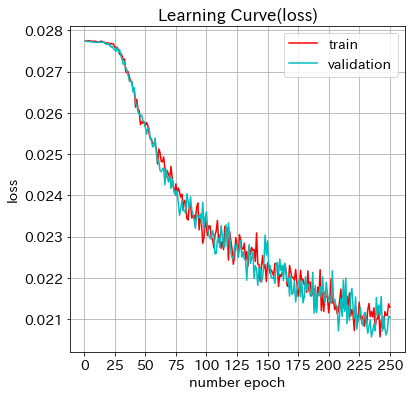

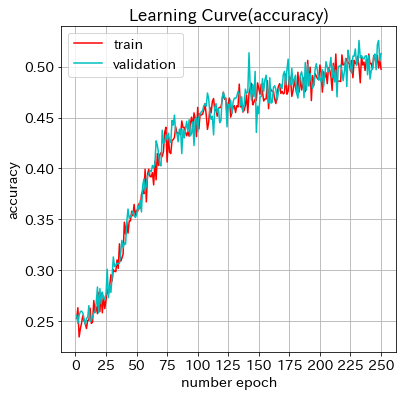

CPU times: user 1h 16min 45s, sys: 26.2 s, total: 1h 17min 11s
Wall time: 2min 24s


In [121]:
%%time
# ミニバッチのサイズ指定
batch_size = 50

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)

class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv1d(batch_size, , 3)
    self.conv2 = nn.Conv1d(10, batch_size, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool1d(5)
    #self.flatten = nn.Flatten()
    self.l1 = nn.Linear(3999, 512)
    self.l2 = nn.Linear(512, n_output)
    
    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x = ( self.features(x.float()) ).float()
    #x = self.flatten(x)
    x = self.classifier(x)
    return x

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.05

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# モデルの概要表示
print(net)

# 損失計算
loss = eval_loss(test_loader1, device, net.float(), criterion.float())

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 200

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

# 評価
evaluate_history(history)